# New CVID data

### Analysis based on GEX and SoupX-denoised protein

Here: removing `doublets` cluster and doublets by BCR or TCR

17.02.2021: reanalysis after marking doublets by BCR and TCR

(Preprocessing happened in notebook M1)

Step-by-step workflow - **different to the scRNA-seq integration in doublet calling**:
- load preprocessed object
- do SCTransfor instead of normalising & log transforming
- save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- filter out cell cycle genes - taking cleaned up genes from the GEX-only object and uniting with protein features
- subset to HVGs
- (skipping scaling, not necessary because we've done SCTransform)
- pca (can also do preliminary neighbors/bbknn+umap here to peak at the data)
- **train a logreg model and add annotation (before it used to be earlier in the workflow)**
- neighbors/bbknn - deciding on which batch correction we will be using
- perform **step 2** of bertie doublet calling (requires running louvain clustering, see code)
- umap
- unbiased clustering
- save

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
# need to do 'pip3 install bbknn==1.3.8' to avoid incompatibility errors
import bbknn
# requires 'pip install scrublet'
#import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
%%bash

pip freeze

aiohttp==3.7.3
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1611176215154/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1610315727443/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1610991770283/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1611678357911/work
blinker==1.

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
annoy               NA
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bbknn               NA
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.4
chardet             3.0.4
cloudpickle         1.6.0
colorama            0.4.4
constants           NA
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.2
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.17.2
jinja2              2.11.2
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.2
jupyterla

## Reading in the main object

In [5]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/'

In [6]:
# reading
adata = sc.read(save_path+'adata_raw_filtered_validation_cohort.h5ad')

In [7]:
adata.var['feature_types-0'].value_counts()

Gene Expression     17254
nan                  4303
Antibody Capture      192
Name: feature_types-0, dtype: int64

In [8]:
# reading indices of cells that were not called as doublets
indices = pd.read_csv('cells_no_doublets_GEX_only_based_validation_cohort_20210210.csv', index_col=0)

### Reading SoupX-denoised protein data (raw)

In [9]:
samples = np.unique(adata.obs['sample'])
samples

array(['35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284',
       '35008_CV005_RV9039261_and_35008_CV005_RV9039285',
       '35008_CV005_RV9039262_and_35008_CV005_RV9039286',
       '35008_CV005_RV9039263_and_35008_CV005_RV9039287',
       '35171_CV005_RV9039361', '35171_CV005_RV9039362',
       '35171_CV005_RV9039363'], dtype=object)

In [10]:
# reading SoupX corrected protein counts (raw)
soupx_denoised_prot = {}

for sample in samples:
    print(sample)
    soupx_denoised_prot[sample] = pd.read_csv('/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/20210212_counts_denoised_with_SoupX_sample_' + sample + '.csv',
                                             index_col=0)
    # getting the barcode indexing to look like the 'cell_id' column in the adata.obs table
    soupx_denoised_prot[sample].columns = [elem.replace('.','-') + '_' + sample for elem in soupx_denoised_prot[sample].columns]
    soupx_denoised_prot[sample].index = [elem.replace('.','-') for elem in soupx_denoised_prot[sample].index]
    soupx_denoised_prot[sample] = soupx_denoised_prot[sample].T

35008_CV005_RV9039258_and_35008_CV005_RV9039282
35008_CV005_RV9039259_and_35008_CV005_RV9039283
35008_CV005_RV9039260_and_35008_CV005_RV9039284
35008_CV005_RV9039261_and_35008_CV005_RV9039285
35008_CV005_RV9039262_and_35008_CV005_RV9039286
35008_CV005_RV9039263_and_35008_CV005_RV9039287
35171_CV005_RV9039361
35171_CV005_RV9039362
35171_CV005_RV9039363


In [11]:
soupx_denoised_prot['35008_CV005_RV9039258_and_35008_CV005_RV9039282']

CD80-1    CD86-1  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...  0.000000  1.533831   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...  1.655727  2.826156   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...  0.000000  0.000000   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...  0.000000  0.000000   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...  0.000000  0.000000   
...                                                      ...       ...   
TTTGTCATCGTACCGG-1_35008_CV005_RV9039258_and_35...  0.000000  0.000000   
TTTGTCATCGTTGCCT-1_35008_CV005_RV9039258_and_35...  0.209406  0.000000   
TTTGTCATCTCAAGTG-1_35008_CV005_RV9039258_and_35...  0.000000  2.788698   
TTTGTCATCTCTGAGA-1_35008_CV005_RV9039258_and_35...  1.083752  0.000000   
TTTGTCATCTGTTGAG-1_35008_CV005_RV9039258_and_35...  0.015072  1.802523   

                                                    CD274(B7-H1)  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...      0.805469   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...      2.006234   
...                                                          ...   
TTTGTCATCGTACCGG-1_35008_CV005_RV9039258_and_35...      0.000000   
TTTGTCATCGTTGCCT-1_35008_CV005_RV9039258_and_35...      0.000000   
TTTGTCATCTCAAGTG-1_35008_CV005_RV9039258_and_35...      1.021803   
TTTGTCATCTCTGAGA-1_35008_CV005_RV9039258_and_35...      0.000000   
TTTGTCATCTGTTGAG-1_35008_CV005_RV9039258_and_35...      0.000000   

                                                    CD273(B7-DC)  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...      2.254152   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...      2.115785   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...      0.000000   
...                                                          ...   
TTTGTCATCGTACCGG-1_35008_CV005_RV9039258_and_35...      0.793204   
TTTGTCATCGTTGCCT-1_35008_CV005_RV9039258_and_35...      0.000000   
TTTGTCATCTCAAGTG-1_35008_CV005_RV9039258_and_35...      0.325714   
TTTGTCATCTCTGAGA-1_35008_CV005_RV9039258_and_35...      0.000000   
TTTGTCATCTGTTGAG-1_35008_CV005_RV9039258_and_35...      0.489873   

                                                    CD275(B7-H2)      CD11b  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...      0.000000  17.246043   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...      0.000000   0.000000   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...      0.000000   0.865683   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...      0.153741   2.645492   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...      0.194955   0.808861   
...                                                          ...        ...   
TTTGTCATCGTACCGG-1_35008_CV005_RV9039258_and_35...      2.604445   4.722219   
TTTGTCATCGTTGCCT-1_35008_CV005_RV9039258_and_35...      0.000000   2.006291   
TTTGTCATCTCAAGTG-1_35008_CV005_RV9039258_and_35...      0.596336   0.000000   
TTTGTCATCTCTGAGA-1_35008_CV005_RV9039258_and_35...      0.830931   1.416465   
TTTGTCATCTGTTGAG-1_35008_CV005_RV9039258_and_35...      0.000000   0.000000   

                                                    CD252(OX40L)  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...      0.372383   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...      0.412204   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...      0.000000   
...                                                          ...   
TTTGTCATCGTACCGG-1_35008_CV005_RV9039258_and_35...      0.000000   
TTTGTCATCGTTGCCT-1_35008_CV005_RV90392

In [12]:
soupx_denoised_prot_joint_table = pd.concat(list(soupx_denoised_prot.values()))

In [13]:
soupx_denoised_prot_joint_table

CD80-1    CD86-1  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...  0.000000  1.533831   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...  1.655727  2.826156   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...  0.000000  0.000000   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...  0.000000  0.000000   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...  0.000000  0.000000   
...                                                      ...       ...   
TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363            4.751022  0.000000   
TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363            2.012104  0.283824   
TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363            3.016310  0.000000   
TTTGTCATCGGCTACG-1_35171_CV005_RV9039363            2.160729  0.000000   
TTTGTCATCTTGGGTA-1_35171_CV005_RV9039363            0.762566  0.000000   

                                                    CD274(B7-H1)  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...      0.805469   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...      2.006234   
...                                                          ...   
TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCGGCTACG-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCTTGGGTA-1_35171_CV005_RV9039363                0.000000   

                                                    CD273(B7-DC)  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...      2.254152   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...      2.115785   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...      0.000000   
...                                                          ...   
TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363                2.011435   
TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCGGCTACG-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCTTGGGTA-1_35171_CV005_RV9039363                0.000000   

                                                    CD275(B7-H2)      CD11b  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...      0.000000  17.246043   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...      0.000000   0.000000   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...      0.000000   0.865683   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...      0.153741   2.645492   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...      0.194955   0.808861   
...                                                          ...        ...   
TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363                0.000000   5.935854   
TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363                0.000000   2.706799   
TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363                0.125238   0.717997   
TTTGTCATCGGCTACG-1_35171_CV005_RV9039363                4.452726  12.631291   
TTTGTCATCTTGGGTA-1_35171_CV005_RV9039363                0.000000   6.042349   

                                                    CD252(OX40L)  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...      0.372383   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...      0.412204   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...      0.000000   
...                                                          ...   
TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCCGCGTTT-1_35171_CV005_RV90393

In [14]:
adata_protein = adata[:,adata.var['feature_types-0'] == 'Antibody Capture'].copy()

In [15]:
for Ab in list(adata_protein.var_names):
    if 'TCR' in Ab:
        print(Ab)

TCR
TCRa/B
TCRVa7.2
TCRVd2
TCRV?9
TCRVa24-Ja18(iNKTcell)
TCR-1


In [16]:
for Ab in list(soupx_denoised_prot_joint_table.columns):
    if 'TCR' in Ab:
        print(Ab)

TCR
TCRa/B
TCRVa7-2
TCRVd2
TCRV?9
TCRVa24-Ja18(iNKTcell)
TCR-1


In [17]:
soupx_denoised_prot_joint_table.columns = [col if col != 'TCRVa7-2' else 'TCRVa7.2' for col in soupx_denoised_prot_joint_table.columns]

In [18]:
soupx_denoised_prot_joint_table = soupx_denoised_prot_joint_table[list(adata_protein.var_names)]

In [19]:
list(adata_protein.var_names)

['CD80-1',
 'CD86-1',
 'CD274(B7-H1)',
 'CD273(B7-DC)',
 'CD275(B7-H2)',
 'CD11b',
 'CD252(OX40L)',
 'CD137L(4-1BBLigand)',
 'CD155(PVR)',
 'CD112(Nectin-2)',
 'CD47-1',
 'CD70-1',
 'CD30',
 'CD40-1',
 'CD154',
 'CD52-1',
 'CD3',
 'CD8',
 'CD56(NCAM)',
 'CD19-1',
 'CD33-1',
 'CD11c',
 'CD34-1',
 'CD269(BCMA)',
 'HLA-ABC',
 'CD90(Thy1)',
 'CD117(c-kit)',
 'CD10',
 'CD45RA',
 'CD123',
 'CD7-1',
 'CD49f',
 'CD194(CCR4)',
 'CD4-1',
 'CD44-1',
 'CD14-1',
 'CD16',
 'CD25',
 'CD45RO',
 'CD279(PD-1)',
 'TIGIT(VSTM3)',
 'Mouse_IgG1',
 'Mouse_IgG2a',
 'Mouse_IgG2b',
 'Rat_IgG2b',
 'CD20',
 'CD335(NKp46)',
 'CD294(CRTH2)',
 'CD326(Ep-CAM)',
 'CD31',
 'Podoplanin',
 'CD146',
 'CD324(E-Cadherin)',
 'IgM',
 'CD5-1',
 'TCR',
 'CD183(CXCR3)',
 'CD195(CCR5)',
 'CD32',
 'CD196(CCR6)',
 'CD185(CXCR5)',
 'CD103(IntegrinaE)',
 'CD69-1',
 'CD62L',
 'CD197(CCR7)',
 'CD161',
 'CD152(CTLA-4)',
 'CD223(LAG-3)',
 'KLRG1(MAFA)',
 'CD27-1',
 'CD107a(LAMP-1)',
 'CD95(Fas)',
 'HLA-DR',
 'CD1c',
 'CD64',
 'CD141(Thro

In [20]:
soupx_denoised_prot_joint_table = soupx_denoised_prot_joint_table.loc[adata.obs['cell_id'],:]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [21]:
# are indices the same?
np.unique(soupx_denoised_prot_joint_table.index == adata.obs['cell_id'])

array([ True])

In [22]:
indices['index']

0           AAACCTGAGAATGTGT-1
1           AAACCTGAGACTAAGT-1
2           AAACCTGAGCCGCCTA-1
3           AAACCTGAGCGCCTCA-1
4           AAACCTGAGGATGTAT-1
                  ...         
107045    TTTGTCATCCCTTGCA-1-1
107046      TTTGTCATCCGCGTTT-1
107047      TTTGTCATCGGAGGTA-1
107048    TTTGTCATCGGCTACG-1-1
107049      TTTGTCATCTTGGGTA-1
Name: index, Length: 107050, dtype: object

In [23]:
# subsetting the adata to non-doublet cells
adata = adata[list(indices['index']),:].copy()

In [24]:
adata.obs

batch   bh_pval  \
index                                  
AAACCTGAGAATGTGT-1       0  0.889727   
AAACCTGAGACTAAGT-1       0  0.889727   
AAACCTGAGCCGCCTA-1       0  0.889727   
AAACCTGAGCGCCTCA-1       0  0.889727   
AAACCTGAGGATGTAT-1       0  0.889727   
...                    ...       ...   
TTTGTCATCCCTTGCA-1-1     8  0.871054   
TTTGTCATCCGCGTTT-1       8  0.949569   
TTTGTCATCGGAGGTA-1       8  0.949569   
TTTGTCATCGGCTACG-1-1     8  0.949569   
TTTGTCATCTTGGGTA-1       8  0.949569   

                                                                cell_id  \
index                                                                     
AAACCTGAGAATGTGT-1    AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGACTAAGT-1    AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGCCGCCTA-1    AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGCGCCTCA-1    AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGGATGTAT-1    AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_3...   
...                                                                 ...   
TTTGTCATCCCTTGCA-1-1           TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363   
TTTGTCATCCGCGTTT-1             TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363   
TTTGTCATCGGAGGTA-1             TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363   
TTTGTCATCGGCTACG-1-1           TTTGTCATCGGCTACG-1_35171_CV005_RV9039363   
TTTGTCATCTTGGGTA-1             TTTGTCATCTTGGGTA-1_35171_CV005_RV9039363   

                           dataset  n_counts  n_genes  percent_mito  \
index                                                                 
AAACCTGAGAATGTGT-1    GEX+CITE-seq    7290.0     2702      0.018107   
AAACCTGAGACTAAGT-1    GEX+CITE-seq   12742.0     3009      0.039083   
AAACCTGAGCCGCCTA-1    GEX+CITE-seq    1274.0      630      0.039246   
AAACCTGAGCGCCTCA-1    GEX+CITE-seq    1137.0      629      0.028144   
AAACCTGAGGATGTAT-1    GEX+CITE-seq    1045.0      571      0.015311   
...                            ...       ...      ...           ...   
TTTGTCATCCCTTGCA-1-1  GEX+CITE-seq   10308.0     2240      0.052581   
TTTGTCATCCGCGTTT-1    GEX+CITE-seq    3022.0     1066      0.014229   
TTTGTCATCGGAGGTA-1    GEX+CITE-seq    3058.0     1076      0.010137   
TTTGTCATCGGCTACG-1-1  GEX+CITE-seq    3490.0     1109      0.008309   
TTTGTCATCTTGGGTA-1    GEX+CITE-seq    3320.0     1070      0.038855   

                                                               sample  \
index                                                                   
AAACCTGAGAATGTGT-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282   
AAACCTGAGACTAAGT-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282   
AAACCTGAGCCGCCTA-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282   
AAACCTGAGCGCCTCA-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282   
AAACCTGAGGATGTAT-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282   
...                                                               ...   
TTTGTCATCCCTTGCA-1-1                            35171_CV005_RV9039363   
TTTGTCATCCGCGTTT-1                              35171_CV005_RV9039363   
TTTGTCATCGGAGGTA-1                              35171_CV005_RV9039363   
TTTGTCATCGGCTACG-1-1                            35171_CV005_RV9039363   
TTTGTCATCTTGGGTA-1                              35171_CV005_RV9039363   

                      scrublet_cluster_score  scrublet_score stimulation  \
index                                                                      
AAACCTGAGAATGTGT-1                  0.121951        0.228916      unstim   
AAACCTGAGACTAAGT-1                  0.101341        0.109890      unstim   
AAACCTGAGCCGCCTA-1                  0.097384        0.045720      unstim   
AAACCTGAGCGCCTCA-1                  0.081753        0.142056      unstim   
AAACCTGAGGATGTAT-1                  0.072961        0.044019      unstim   
...                                      ...             ...         ...   
TTTGTCATCCCTTGCA-1-1                0.0972

In [25]:
soupx_denoised_prot_joint_table = soupx_denoised_prot_joint_table.loc[adata.obs['cell_id'],:]

In [26]:
soupx_denoised_prot_joint_table

CD80-1    CD86-1  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...  0.000000  1.533831   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...  1.655727  2.826156   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...  0.000000  0.000000   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...  0.000000  0.000000   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...  0.000000  0.000000   
...                                                      ...       ...   
TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363            4.751022  0.000000   
TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363            2.012104  0.283824   
TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363            3.016310  0.000000   
TTTGTCATCGGCTACG-1_35171_CV005_RV9039363            2.160729  0.000000   
TTTGTCATCTTGGGTA-1_35171_CV005_RV9039363            0.762566  0.000000   

                                                    CD274(B7-H1)  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...      0.805469   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...      2.006234   
...                                                          ...   
TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCGGCTACG-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCTTGGGTA-1_35171_CV005_RV9039363                0.000000   

                                                    CD273(B7-DC)  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...      2.254152   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...      2.115785   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...      0.000000   
...                                                          ...   
TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363                2.011435   
TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCGGCTACG-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCTTGGGTA-1_35171_CV005_RV9039363                0.000000   

                                                    CD275(B7-H2)      CD11b  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...      0.000000  17.246043   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...      0.000000   0.000000   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...      0.000000   0.865683   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...      0.153741   2.645492   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...      0.194955   0.808861   
...                                                          ...        ...   
TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363                0.000000   5.935854   
TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363                0.000000   2.706799   
TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363                0.125238   0.717997   
TTTGTCATCGGCTACG-1_35171_CV005_RV9039363                4.452726  12.631291   
TTTGTCATCTTGGGTA-1_35171_CV005_RV9039363                0.000000   6.042349   

                                                    CD252(OX40L)  \
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...      0.000000   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...      0.372383   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...      0.412204   
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35...      0.000000   
...                                                          ...   
TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363                0.000000   
TTTGTCATCCGCGTTT-1_35171_CV005_RV90393

In [27]:
mtx_to_add = np.nan_to_num(soupx_denoised_prot_joint_table.values)
mtx_to_add = scipy.sparse.csr_matrix(mtx_to_add)

In [28]:
mtx_to_add

<107050x192 sparse matrix of type '<class 'numpy.float64'>'
	with 7174212 stored elements in Compressed Sparse Row format>

In [29]:
adata[:,adata.var['feature_types-0'] == 'Antibody Capture'].X

<107050x192 sparse matrix of type '<class 'numpy.float32'>'
	with 16199710 stored elements in Compressed Sparse Row format>

In [30]:
adata[:,adata.var['feature_types-0'] == 'Antibody Capture'].X = mtx_to_add

In [31]:
adata

AnnData object with n_obs × n_vars = 107050 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8'

In [32]:
# adding final annotation
annotation = pd.read_csv(save_path + 'annotation_GEX_and_SoupX_denoised_protein_20210217.csv', index_col=0)
adata.obs['cell_type'] = annotation.loc[adata.obs_names, 'cell_type']

In [33]:
# getting the full metadata table
adata4cellxgene = sc.read(save_path+'adata_for_cellxgene_GEX_and_SoupX_denoised_protein_BBKNN_validation_cohort_20210212.h5ad')

In [34]:
adata4cellxgene

AnnData object with n_obs × n_vars = 107050 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5',

In [35]:
# adding all the metadata to this object
for col in adata4cellxgene.obs.columns:
    print(col)
    adata.obs[col] = adata4cellxgene.obs.loc[adata.obs_names,col]

batch
bh_pval
cell_id
dataset
n_counts
n_genes
percent_mito
sample
scrublet_cluster_score
scrublet_score
stimulation
technique
is_doublet
donor
prelim_annot
celltype_predictions
probabilities
S_score
G2M_score
phase
n_counts_protein
n_counts_protein_lognorm
louvain
barcode
Age
Sex
Age of disease onset
Autoimmunity
Gastrointestinal disease
Lung disease (bronchiectasis)
Lymphoadenopathy 
Splenomegaly
History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members
CVID_status


In [36]:
adata

AnnData object with n_obs × n_vars = 107050 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feat

In [37]:
adata.var['feature_types-0'].value_counts()

Gene Expression     17254
nan                  4303
Antibody Capture      192
Name: feature_types-0, dtype: int64

In [38]:
np.unique(adata.obs['sample'])

array(['35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284',
       '35008_CV005_RV9039261_and_35008_CV005_RV9039285',
       '35008_CV005_RV9039262_and_35008_CV005_RV9039286',
       '35008_CV005_RV9039263_and_35008_CV005_RV9039287',
       '35171_CV005_RV9039361', '35171_CV005_RV9039362',
       '35171_CV005_RV9039363'], dtype=object)

In [39]:
adata_GEX_check = adata[:, adata.var['feature_types-0'] != 'Antibody Capture'].copy()
adata_protein_check = adata[:, adata.var['feature_types-0'] == 'Antibody Capture'].copy()


In [40]:
# quick check to see if the values are integer
expr_mtx_gex = adata_GEX_check[adata_GEX_check.obs['sample'] == '35171_CV005_RV9039361'].X.todense()
np.unique(expr_mtx_gex)

matrix([[   0.,    0.,    0., ..., 6624., 7759., 7780.]], dtype=float32)

In [41]:
# quick check to see if the values are integer
expr_mtx_protein = adata_protein_check[adata_protein_check.obs['sample'] == '35171_CV005_RV9039361'].X.todense()
np.unique(expr_mtx_protein)

matrix([[    0.   ,     0.   ,     0.   , ..., 32472.53 , 33553.68 ,
         45594.797]], dtype=float32)

### So the denoised protein values are not integer after SoupX, but GEX is, so everything is fine, moving on.

## Reading tables of doublets by BCR and by TCR

In [42]:
adata

AnnData object with n_obs × n_vars = 107050 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feat

In [43]:
doublets_by_BCR = pd.read_csv(save_path + 'doublets_by_BCR_table_20210217.csv',
                         index_col=0)
np.unique(doublets_by_BCR['doublets_by_BCR'], return_counts=True)

(array([False,  True]), array([104986,   2064]))

In [44]:
doublets_by_TCR = pd.read_csv(save_path + 'doublets_by_TCR_table_20210217.csv',
                             index_col=0)
np.unique(doublets_by_TCR['doublets_by_TCR'], return_counts=True)

(array([False,  True]), array([96793, 10257]))

In [45]:
doublets_by_TCR.shape

(107050, 1)

In [46]:
doublets_by_BCR[doublets_by_BCR['doublets_by_BCR'] == False]

doublets_by_BCR
index                                
AAACCTGAGAATGTGT-1              False
AAACCTGAGACTAAGT-1              False
AAACCTGAGCCGCCTA-1              False
AAACCTGAGCGCCTCA-1              False
AAACCTGAGGATGTAT-1              False
...                               ...
TTTGTCATCCCTTGCA-1-1            False
TTTGTCATCCGCGTTT-1              False
TTTGTCATCGGAGGTA-1              False
TTTGTCATCGGCTACG-1-1            False
TTTGTCATCTTGGGTA-1              False

[104986 rows x 1 columns]

In [47]:
cells_not_BCR_doublets = list(doublets_by_BCR[doublets_by_BCR['doublets_by_BCR'] == False].index)
len(cells_not_BCR_doublets)

104986

In [48]:
cells_not_TCR_doublets = list(doublets_by_TCR[doublets_by_TCR['doublets_by_TCR'] == False].index)
len(cells_not_TCR_doublets)

96793

In [49]:
cells_no_doublets = list(set(cells_not_BCR_doublets) & set(cells_not_TCR_doublets))
len(cells_no_doublets)

95064

In [50]:
cells_BCR_doublets = list(doublets_by_BCR[doublets_by_BCR['doublets_by_BCR'] == True].index)
len(cells_BCR_doublets)

2064

In [51]:
cells_TCR_doublets = list(doublets_by_TCR[doublets_by_TCR['doublets_by_TCR'] == True].index)
len(cells_TCR_doublets)

10257

In [52]:
# unique barcodes
cells_BCR_TCR_doublets = list(set(cells_BCR_doublets + cells_TCR_doublets))
len(cells_BCR_TCR_doublets)

11986

In [53]:
107050 - 11986

95064

In [54]:
# actually excluding TCR and BCR doublets / SUBSETTING
adata = adata[cells_no_doublets, :].copy()

In [55]:
adata

AnnData object with n_obs × n_vars = 95064 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'featu

___________

Carrying on to 
- Normalise and log transform
- Save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- Make cell names (obs) and gene names (var) unique

In [56]:
# normalise and log transform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

# saving the raw attribute
adata.raw = adata.copy()

adata.var_names_make_unique()
adata.obs_names_make_unique()

normalizing by total count per cell
    finished (0:00:05): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


_____________________________________________________________________________________________________________________________________________________________

### Filter Cell cycle genes 

Getting the GEX-only based cleaned up genes (CC-asssociated genes removed), taking those and adding protein

In [57]:
genes_no_ccg = pd.read_csv('./genes_no_CC_associated_genes_new_20210209.csv', index_col=0)

In [58]:
genes_no_ccg

index
0       RP11-34P13.7
1         FO538757.2
2         AP006222.2
3      RP4-669L17.10
4       RP5-857K21.4
...              ...
21454  CTD-2541M15.3
21455          THEGL
21456       KIAA1644
21457   RP11-132A1.3
21458  RP11-111H13.1

[21459 rows x 1 columns]

In [59]:
adata_protein

AnnData object with n_obs × n_vars = 112463 × 192
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8'

In [60]:
Abs = list(adata_protein.var_names)
Abs

['CD80-1',
 'CD86-1',
 'CD274(B7-H1)',
 'CD273(B7-DC)',
 'CD275(B7-H2)',
 'CD11b',
 'CD252(OX40L)',
 'CD137L(4-1BBLigand)',
 'CD155(PVR)',
 'CD112(Nectin-2)',
 'CD47-1',
 'CD70-1',
 'CD30',
 'CD40-1',
 'CD154',
 'CD52-1',
 'CD3',
 'CD8',
 'CD56(NCAM)',
 'CD19-1',
 'CD33-1',
 'CD11c',
 'CD34-1',
 'CD269(BCMA)',
 'HLA-ABC',
 'CD90(Thy1)',
 'CD117(c-kit)',
 'CD10',
 'CD45RA',
 'CD123',
 'CD7-1',
 'CD49f',
 'CD194(CCR4)',
 'CD4-1',
 'CD44-1',
 'CD14-1',
 'CD16',
 'CD25',
 'CD45RO',
 'CD279(PD-1)',
 'TIGIT(VSTM3)',
 'Mouse_IgG1',
 'Mouse_IgG2a',
 'Mouse_IgG2b',
 'Rat_IgG2b',
 'CD20',
 'CD335(NKp46)',
 'CD294(CRTH2)',
 'CD326(Ep-CAM)',
 'CD31',
 'Podoplanin',
 'CD146',
 'CD324(E-Cadherin)',
 'IgM',
 'CD5-1',
 'TCR',
 'CD183(CXCR3)',
 'CD195(CCR5)',
 'CD32',
 'CD196(CCR6)',
 'CD185(CXCR5)',
 'CD103(IntegrinaE)',
 'CD69-1',
 'CD62L',
 'CD197(CCR7)',
 'CD161',
 'CD152(CTLA-4)',
 'CD223(LAG-3)',
 'KLRG1(MAFA)',
 'CD27-1',
 'CD107a(LAMP-1)',
 'CD95(Fas)',
 'HLA-DR',
 'CD1c',
 'CD64',
 'CD141(Thro

In [61]:
cleaned_up_genes = list(genes_no_ccg['index'])
cleaned_up_genes[:5]

['RP11-34P13.7', 'FO538757.2', 'AP006222.2', 'RP4-669L17.10', 'RP5-857K21.4']

In [62]:
# subsetting to cleaned up genes (based on GEX-only analysis) and protein features
adata = adata[:,cleaned_up_genes + Abs].copy()


In [63]:
adata

AnnData object with n_obs × n_vars = 95064 × 21651
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'featu

In [64]:
%%time
# Assign cell cycle stage & scores
cell_cycle_genes = [x.strip() for x in open(file='/home/jovyan/notebooks/Vento_Lab/regev_lab_cell_cycle_genes_from_Luz_20200505.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

# takes a few minutes

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    389 total control genes are used. (0:00:06)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    466 total control genes are used. (0:00:03)
-->     'phase', cell cycle phase (adata.obs)
CPU times: user 5.29 s, sys: 4.8 s, total: 10.1 s
Wall time: 10.1 s


In [65]:
adata

AnnData object with n_obs × n_vars = 95064 × 21651
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'featu

In [66]:
adata.var['feature_types-0'].value_counts()

Gene Expression     17157
nan                  4302
Antibody Capture      192
Name: feature_types-0, dtype: int64

_______________________________________________________________________________________________________

# Subsetting to HVGs and scaling

In [67]:
%%time
#adata_gex = adata.copy()
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
CPU times: user 5.44 s, sys: 92 ms, total: 5.53 s
Wall time: 5.53 s


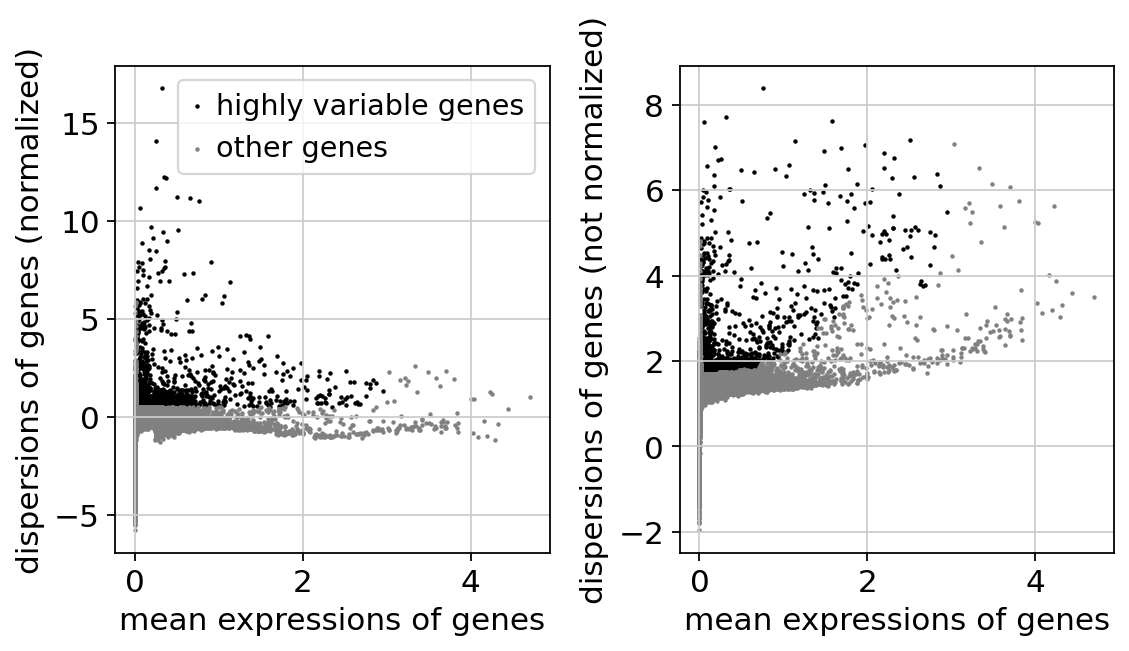

CPU times: user 392 ms, sys: 12 ms, total: 404 ms
Wall time: 403 ms


In [68]:
%%time
sc.pl.highly_variable_genes(adata)

In [69]:
adata_hvg = adata[:, adata.var['highly_variable']]

In [70]:
adata_hvg

View of AnnData object with n_obs × n_vars = 95064 × 2627
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5',

In [71]:
%%time
sc.pp.scale(adata_hvg, max_value=10)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
CPU times: user 3.15 s, sys: 1.66 s, total: 4.81 s
Wall time: 4.81 s


________

## PCA

In [72]:
%%time
sc.tl.pca(adata_hvg, svd_solver='arpack', n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:21)
CPU times: user 1min 51s, sys: 1min 43s, total: 3min 34s
Wall time: 21.9 s


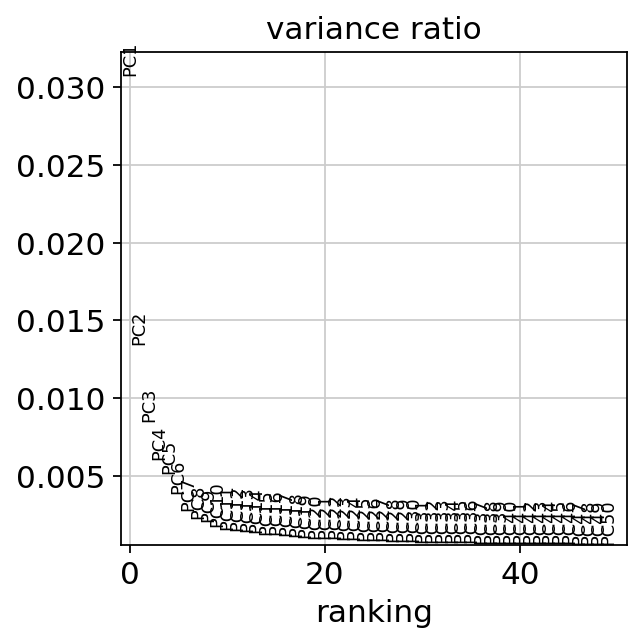

In [73]:
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50)

_______

### Neighbourhood graph & UMAP

### BBKNN by `sample`


In [74]:
%%time
bbknn.bbknn(adata_hvg, batch_key='sample')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:25)
CPU times: user 25.2 s, sys: 48 ms, total: 25.2 s
Wall time: 25.2 s


/opt/conda/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/opt/conda/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


__________________________________________________________________________________________________________________________________________________________________

In [75]:
%%time
sc.tl.umap(adata_hvg, random_state=0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:17)
CPU times: user 3min 13s, sys: 1min 19s, total: 4min 33s
Wall time: 2min 17s


# Plotting

In [76]:
adata_hvg

AnnData object with n_obs × n_vars = 95064 × 2627
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'featur

In [77]:
markers = ['CD4','CD3G', 'FOXJ1', 'IL2R', 'TRDV2', 'CD8', # T cells
                             'CD19', 'MS4A1', # B cells
                              'CD27', 'CD38', 'JCHAIN', # Plasma B cells
                             'NCAM1', 'FCGR3A', # NK celss
                             'HBB', # Erythrocytes
                             'FCGR3B', # Neutrophils
                             'CD14', 'S100A12', # Monocytes
                             'FLT3', # Dendritic cells
                             'IRF4', 'CLEC9A', # cDC1
                             'CD1C', # cDC2
                             'TNFRSF21', # pDC and IRF4
                             'CD34', # Precursors
                             'PPBP', 'TUBB1', 'PF4', # Platelets
                             'MI67', # cycling
                            ]

### BBKNN by `sample`

50 PCs

... storing 'cell_type' as categorical
... storing 'phase' as categorical


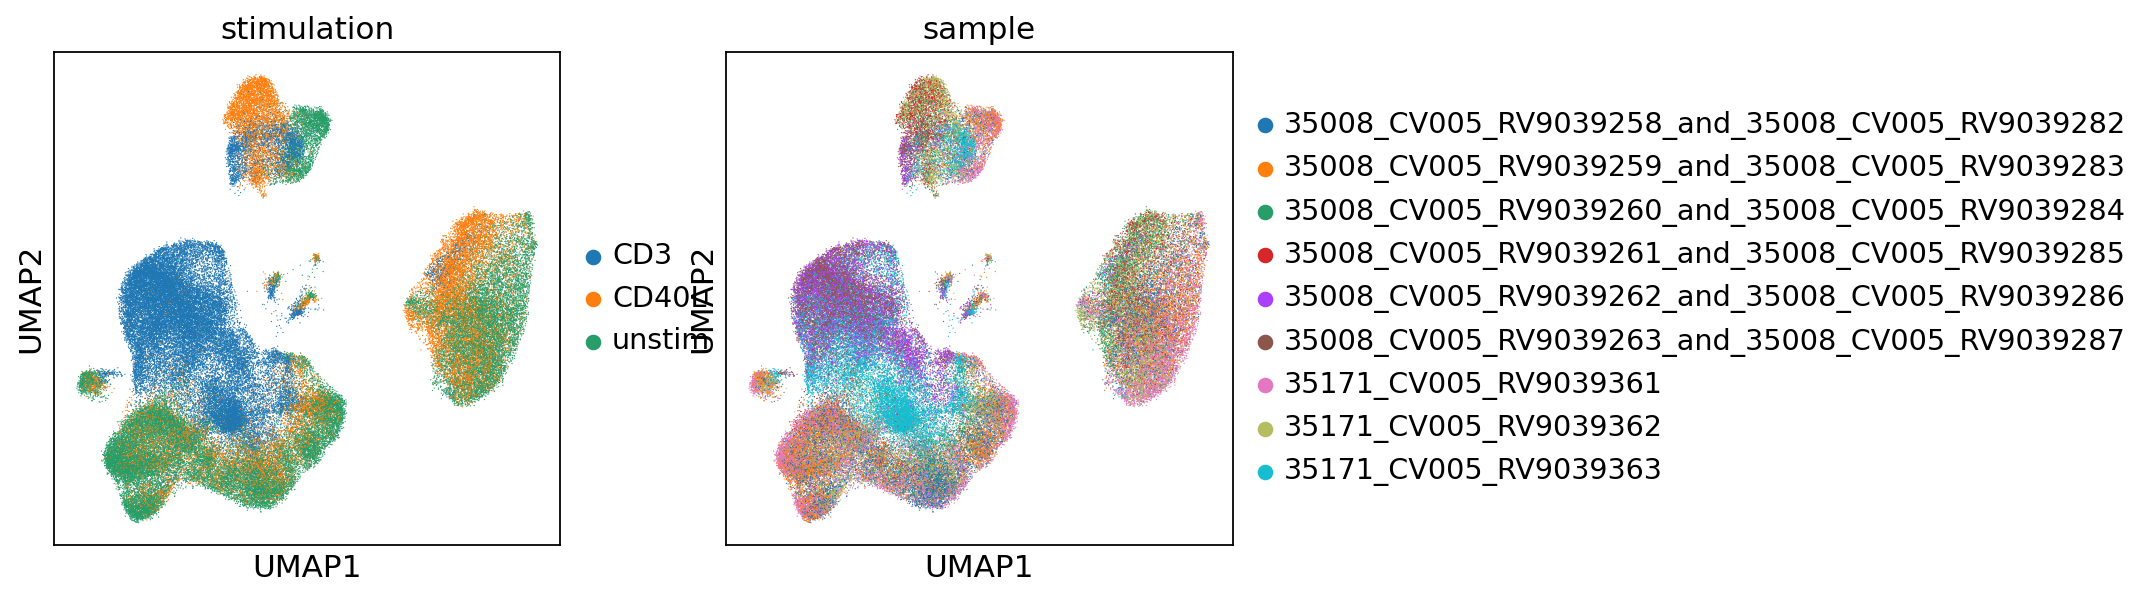

In [78]:
sc.pl.umap(adata_hvg, color=['stimulation','sample'])

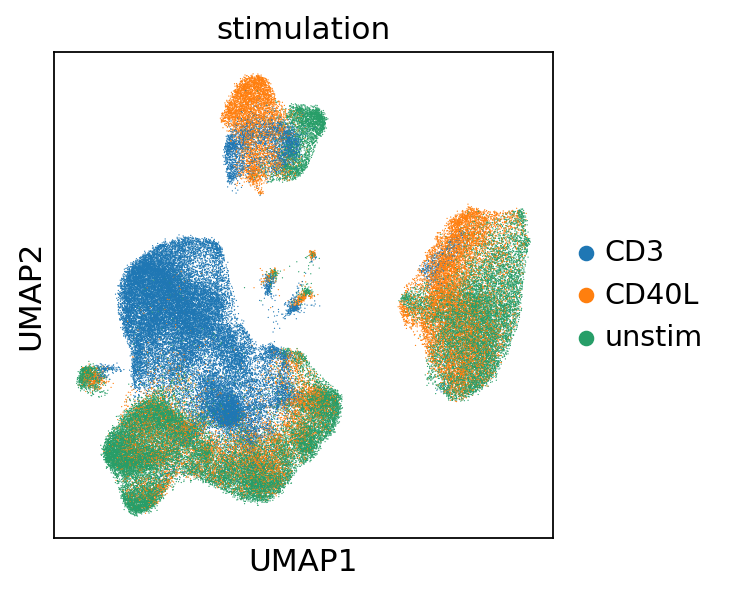

In [79]:
sc.pl.umap(adata_hvg, color=['stimulation'])

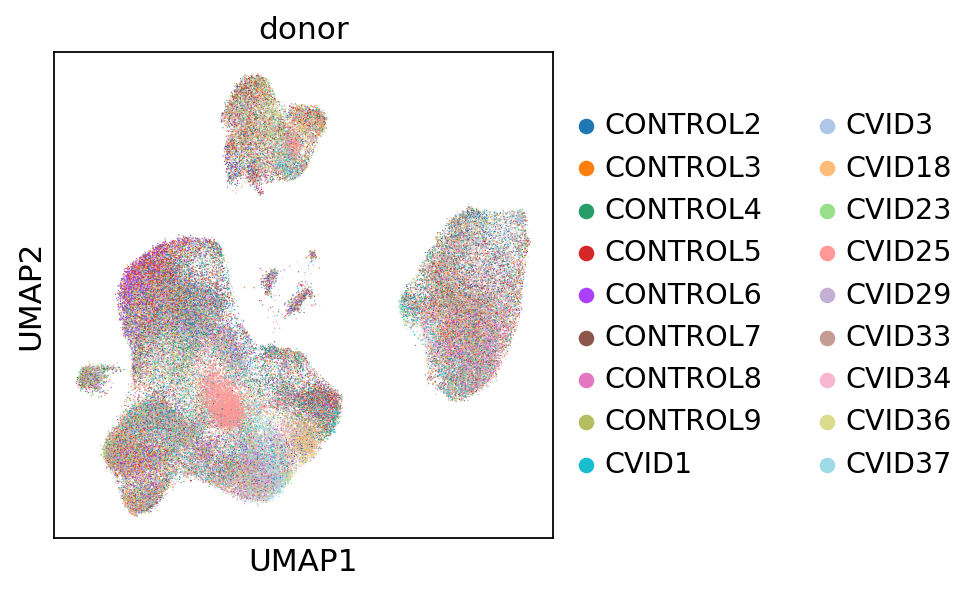

In [80]:
sc.pl.umap(adata_hvg, color=['donor'])

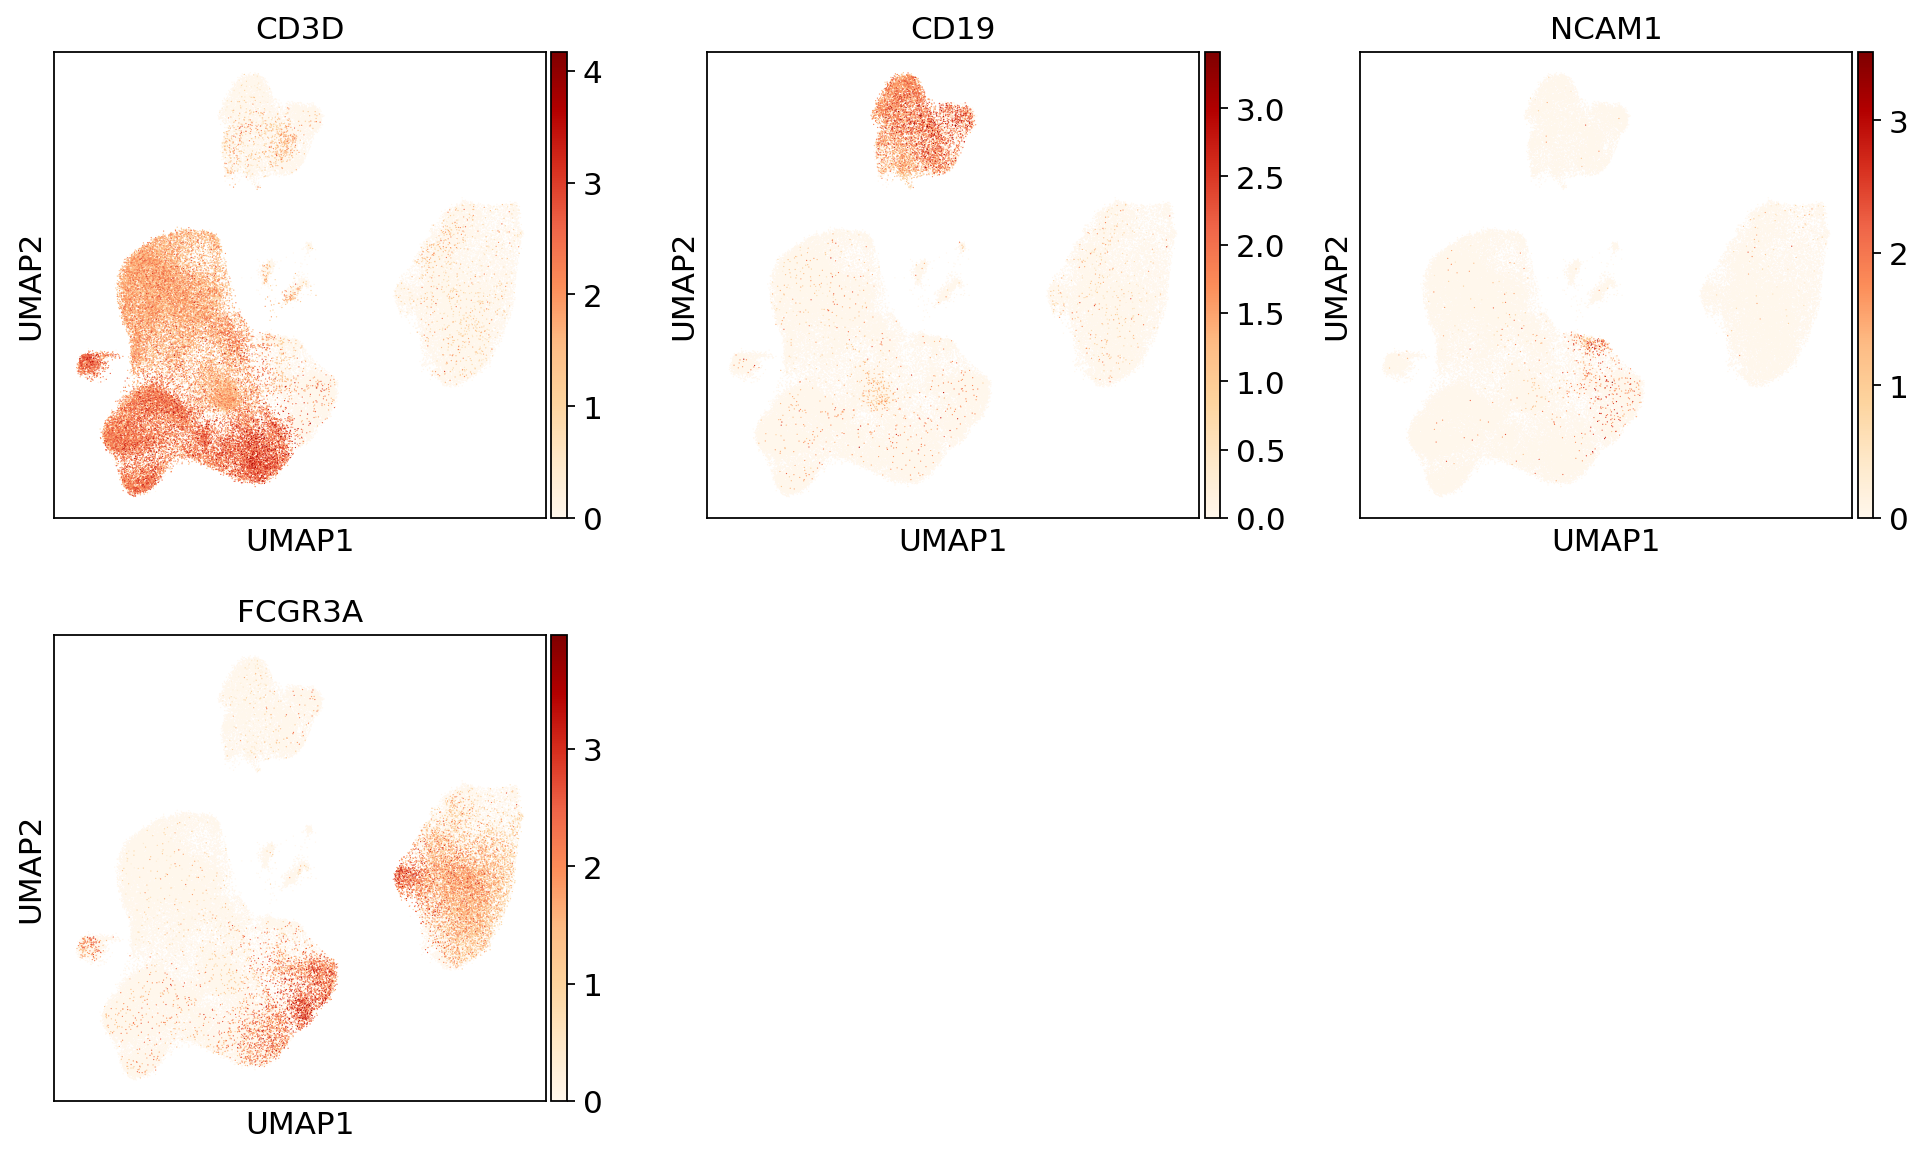

In [81]:
sc.pl.umap(adata_hvg, color=['CD3D', # T cells
                             'CD19', # B cells
                             # NK markers
                             'NCAM1', # CD56
                             'FCGR3A', # CD16
                            ], ncols=3, use_raw=True, cmap='OrRd')

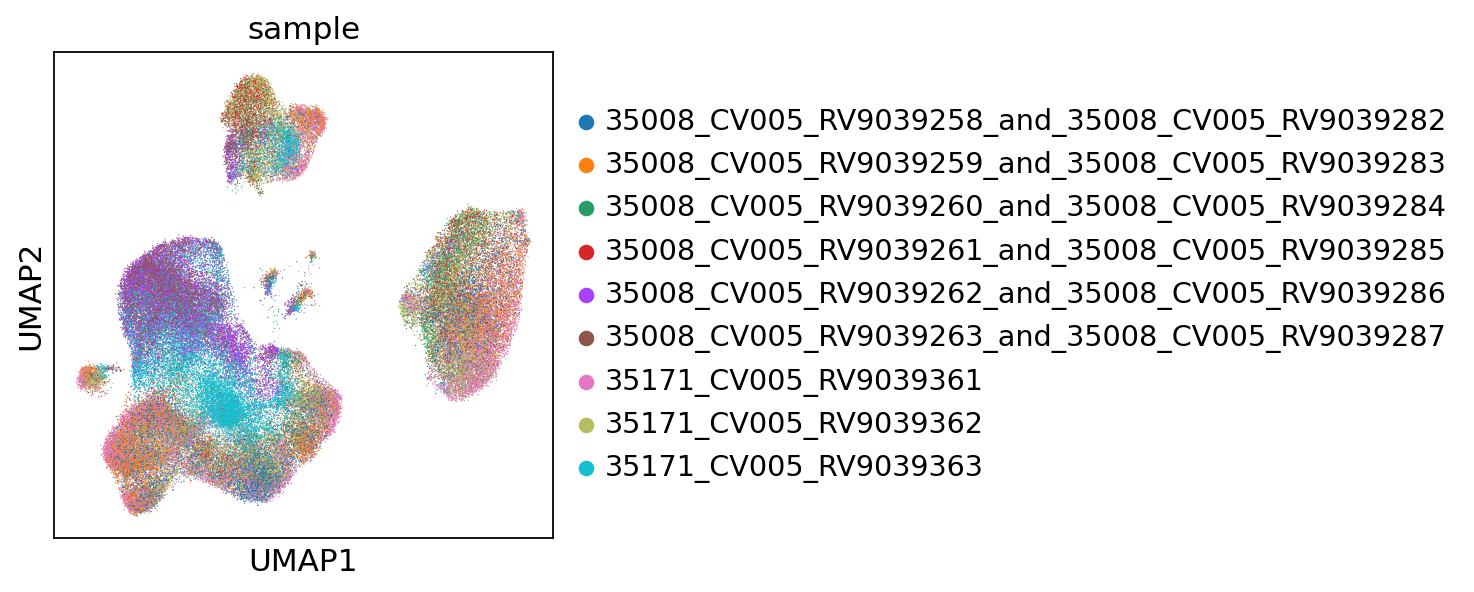

In [82]:
sc.pl.umap(adata_hvg, color=['sample'])

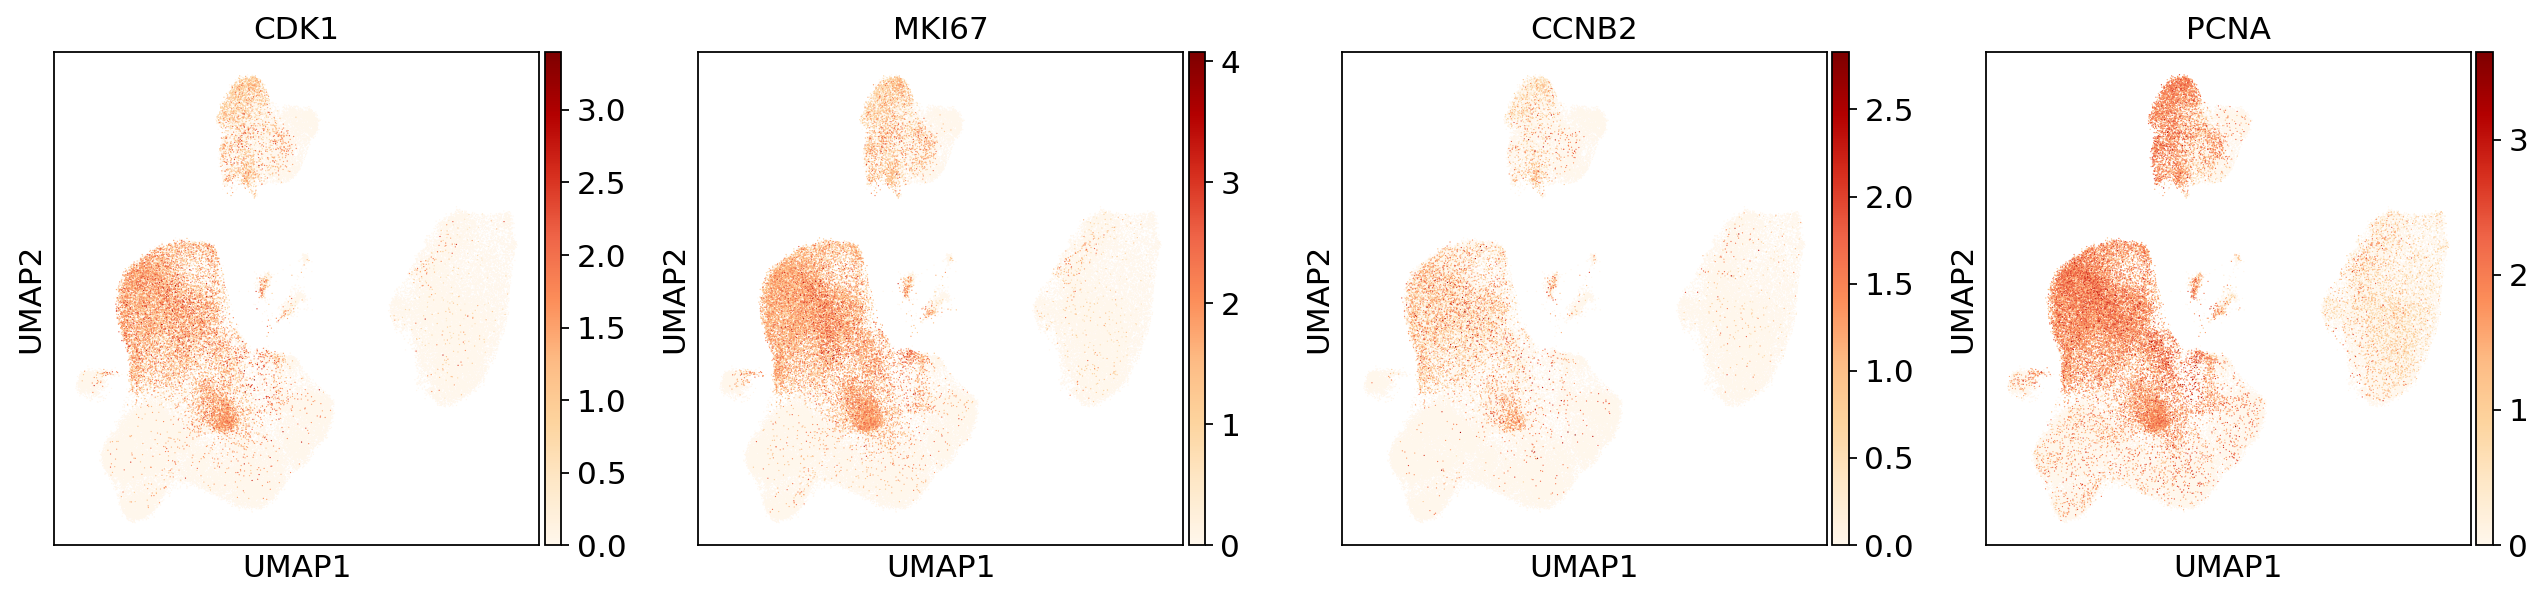

In [83]:
sc.pl.umap(adata_hvg, color=['CDK1','MKI67','CCNB2','PCNA'], cmap='OrRd')

In [84]:
adata_hvg

AnnData object with n_obs × n_vars = 95064 × 2627
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'featur

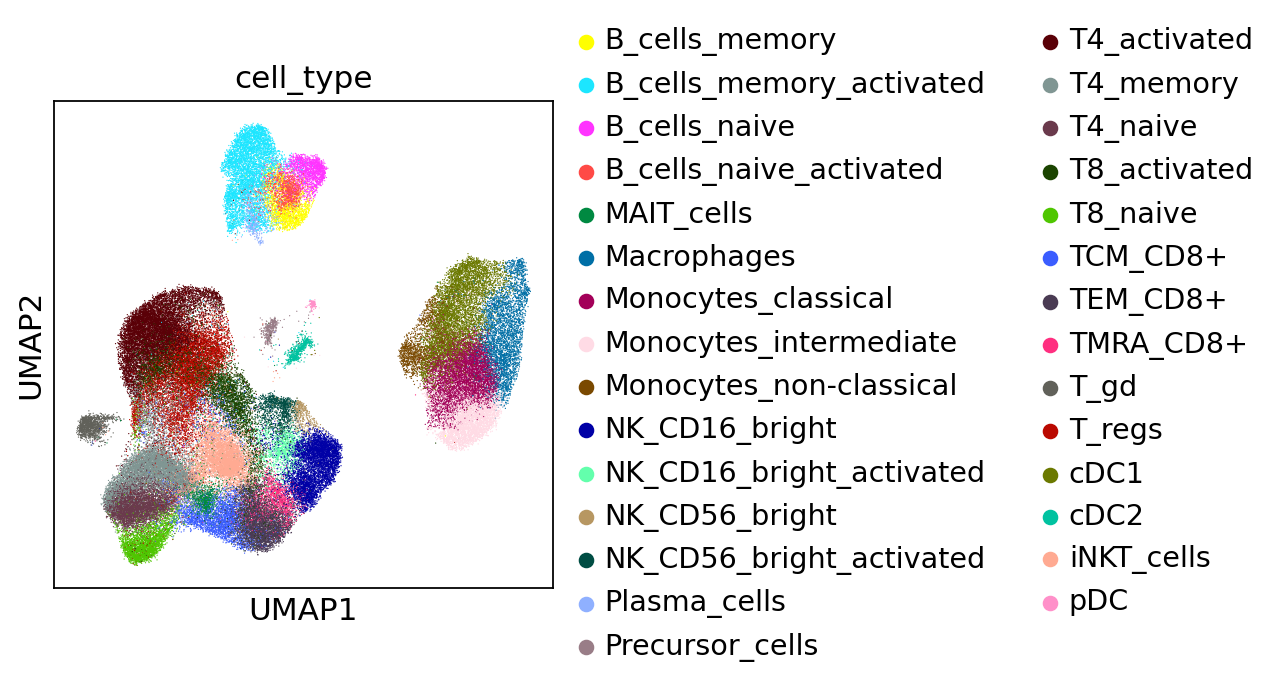

In [85]:
sc.pl.umap(adata_hvg, color=['cell_type'])

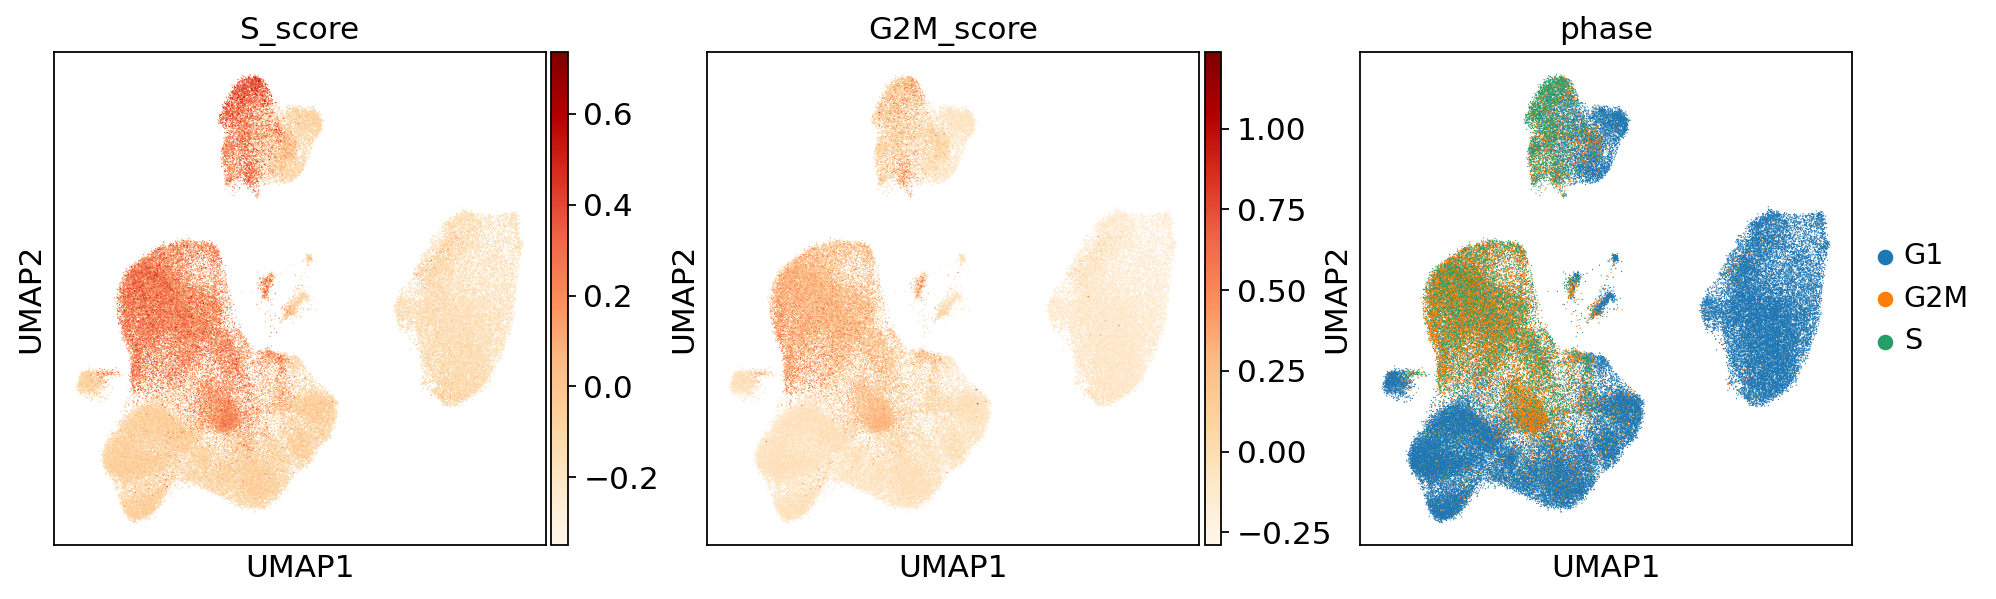

In [86]:
sc.pl.umap(adata_hvg, color=['S_score','G2M_score','phase'], cmap='OrRd')

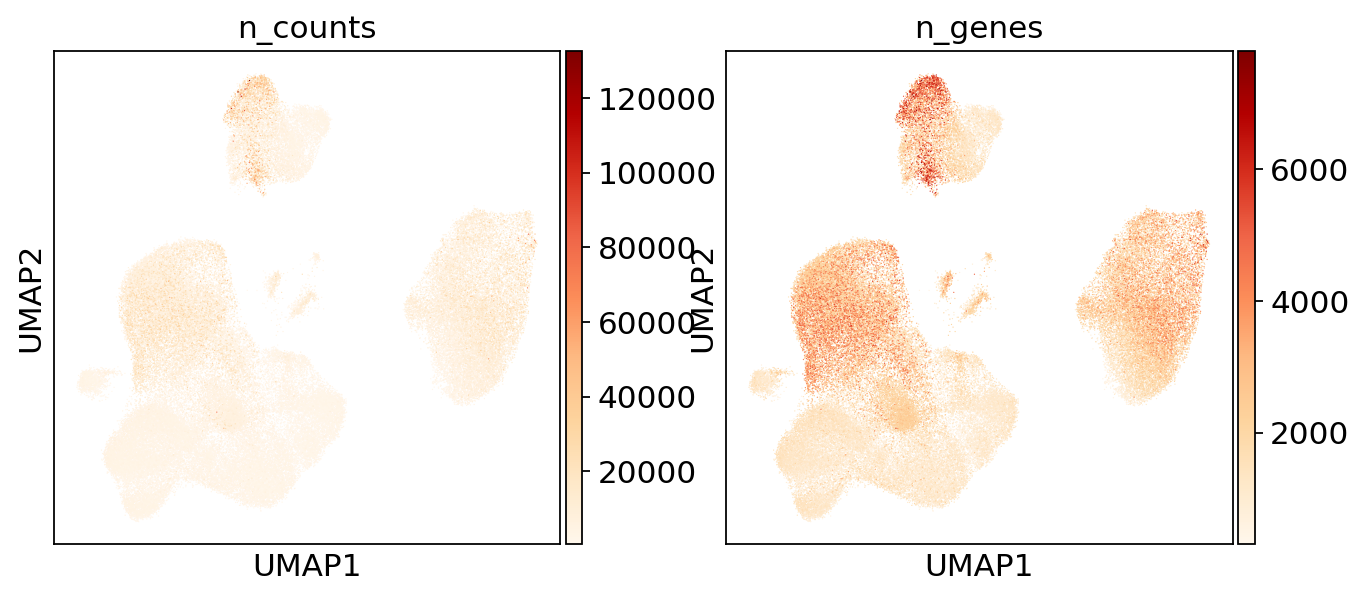

In [87]:
sc.pl.umap(adata_hvg, color=['n_counts',
                             'n_genes'], cmap='OrRd')

In [88]:
# are any proteins in HVGs?
adata_prot = adata_hvg[:, adata_hvg.var['feature_types-0'] == 'Antibody Capture'].copy()
adata_prot

AnnData object with n_obs × n_vars = 95064 × 145
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature

In [91]:
Abs = list(adata_hvg.raw[:, adata_hvg.raw.var['feature_types-0'] == 'Antibody Capture'].var_names)

In [92]:
len(Abs)

192

In [ ]:
# takes a few minutes
# already done
sc.pl.umap(adata_hvg, color=Abs, cmap='OrRd',
          save='_protein_joint_GEX_and_SoupX_denoised_protein_manifold_validation_cohort_final_object_20210217.pdf')

### Plotting per sample donor stats

In [94]:
df_stats = pd.DataFrame(columns=list(np.unique(adata_hvg.obs['donor'])),
                     index=list(np.unique(adata_hvg.obs['sample'])))

In [95]:
df_stats

CONTROL2 CONTROL3 CONTROL4  \
35008_CV005_RV9039258_and_35008_CV005_RV9039282      NaN      NaN      NaN   
35008_CV005_RV9039259_and_35008_CV005_RV9039283      NaN      NaN      NaN   
35008_CV005_RV9039260_and_35008_CV005_RV9039284      NaN      NaN      NaN   
35008_CV005_RV9039261_and_35008_CV005_RV9039285      NaN      NaN      NaN   
35008_CV005_RV9039262_and_35008_CV005_RV9039286      NaN      NaN      NaN   
35008_CV005_RV9039263_and_35008_CV005_RV9039287      NaN      NaN      NaN   
35171_CV005_RV9039361                                NaN      NaN      NaN   
35171_CV005_RV9039362                                NaN      NaN      NaN   
35171_CV005_RV9039363                                NaN      NaN      NaN   

                                                CONTROL5 CONTROL6 CONTROL7  \
35008_CV005_RV9039258_and_35008_CV005_RV9039282      NaN      NaN      NaN   
35008_CV005_RV9039259_and_35008_CV005_RV9039283      NaN      NaN      NaN   
35008_CV005_RV9039260_and_35008_CV005_RV9039284      NaN      NaN      NaN   
35008_CV005_RV9039261_and_35008_CV005_RV9039285      NaN      NaN      NaN   
35008_CV005_RV9039262_and_35008_CV005_RV9039286      NaN      NaN      NaN   
35008_CV005_RV9039263_and_35008_CV005_RV9039287      NaN      NaN      NaN   
35171_CV005_RV9039361                                NaN      NaN      NaN   
35171_CV005_RV9039362                                NaN      NaN      NaN   
35171_CV005_RV9039363                                NaN      NaN      NaN   

                                                CONTROL8 CONTROL9 CVID1  \
35008_CV005_RV9039258_and_35008_CV005_RV9039282      NaN      NaN   NaN   
35008_CV005_RV9039259_and_35008_CV005_RV9039283      NaN      NaN   NaN   
35008_CV005_RV9039260_and_35008_CV005_RV9039284      NaN      NaN   NaN   
35008_CV005_RV9039261_and_35008_CV005_RV9039285      NaN      NaN   NaN   
35008_CV005_RV9039262_and_35008_CV005_RV9039286      NaN      NaN   NaN   
35008_CV005_RV9039263_and_35008_CV005_RV9039287      NaN      NaN   NaN   
35171_CV005_RV9039361                                NaN      NaN   NaN   
35171_CV005_RV9039362                                NaN      NaN   NaN   
35171_CV005_RV9039363                                NaN      NaN   NaN   

                                                CVID18 CVID23 CVID25 CVID29  \
35008_CV005_RV9039258_and_35008_CV005_RV9039282    NaN    NaN    NaN    NaN   
35008_CV005_RV9039259_and_35008_CV005_RV9039283    NaN    NaN    NaN    NaN   
35008_CV005_RV9039260_and_35008_CV005_RV9039284    NaN    NaN    NaN    NaN   
35008_CV005_RV9039261_and_35008_CV005_RV9039285    NaN    NaN    NaN    NaN   
35008_CV005_RV9039262_and_35008_CV005_RV9039286    NaN    NaN    NaN    NaN   
35008_CV005_RV9039263_and_35008_CV005_RV9039287    NaN    NaN    NaN    NaN   
35171_CV005_RV9039361                              NaN    NaN    NaN    NaN   
35171_CV005_RV9039362                              NaN    NaN    NaN    NaN   
35171_CV005_RV9039363                              NaN    NaN    NaN    NaN   

                                                CVID3 CVID33 CVID34 CVID36  \
35008_CV005_RV9039258_and_35008_CV005_RV9039282   NaN    NaN    NaN    NaN   
35008_CV005_RV9039259_and_35008_CV005_RV9039283   NaN    NaN    NaN    NaN   
35008_CV005_RV9039260_and_35008_CV005_RV9039284   NaN    NaN    NaN    NaN   
35008_CV005_RV9039261_and_35008_CV005_RV9039285   NaN    NaN    NaN    NaN   
35008_CV005_RV9039262_and_35008_CV005_RV9039286   NaN    NaN    NaN    NaN   
35008_CV005_RV9039263_and_35008_CV005_RV9039287   NaN    NaN    NaN    NaN   
35171_CV005_RV9039361                             NaN    NaN    NaN    NaN   
35171_CV005_RV9039362                             NaN    NaN    NaN    NaN   
35171_CV005_RV9039363                             NaN    NaN    NaN    NaN   

                                                CVID37  
35008_CV005_RV9039258_and_35008_CV005_RV9039282    NaN  
35008_CV005_RV9039259_and_35008_CV005_RV9039283  

In [96]:
for donor in df_stats.columns:
    print('donor', donor)
    for sample in df_stats.index:
        #print(sample)
        df_stats.loc[sample, donor] = adata_hvg[(adata_hvg.obs['donor'] == donor)
                                         & (adata_hvg.obs['sample'] == sample)].X.shape[0]

donor CONTROL2
donor CONTROL3
donor CONTROL4
donor CONTROL5
donor CONTROL6
donor CONTROL7
donor CONTROL8
donor CONTROL9
donor CVID1
donor CVID18
donor CVID23
donor CVID25
donor CVID29
donor CVID3
donor CVID33
donor CVID34
donor CVID36
donor CVID37


In [97]:
df_stats

CONTROL2  CONTROL3  CONTROL4  \
35008_CV005_RV9039258_and_35008_CV005_RV9039282         0         0      1706   
35008_CV005_RV9039259_and_35008_CV005_RV9039283      1745      2112         0   
35008_CV005_RV9039260_and_35008_CV005_RV9039284         0         0       750   
35008_CV005_RV9039261_and_35008_CV005_RV9039285       876       715         0   
35008_CV005_RV9039262_and_35008_CV005_RV9039286         0         0      1736   
35008_CV005_RV9039263_and_35008_CV005_RV9039287      1943      1693         0   
35171_CV005_RV9039361                                   0         0         0   
35171_CV005_RV9039362                                   0         0         0   
35171_CV005_RV9039363                                   0         0         0   

                                                 CONTROL5  CONTROL6  CONTROL7  \
35008_CV005_RV9039258_and_35008_CV005_RV9039282         0      2085         0   
35008_CV005_RV9039259_and_35008_CV005_RV9039283      2009         0         0   
35008_CV005_RV9039260_and_35008_CV005_RV9039284         0       825         0   
35008_CV005_RV9039261_and_35008_CV005_RV9039285       945         0         0   
35008_CV005_RV9039262_and_35008_CV005_RV9039286         0      2730         0   
35008_CV005_RV9039263_and_35008_CV005_RV9039287      2292         0         0   
35171_CV005_RV9039361                                   0         0      1472   
35171_CV005_RV9039362                                   0         0      2145   
35171_CV005_RV9039363                                   0         0      1075   

                                                 CONTROL8  CONTROL9  CVID1  \
35008_CV005_RV9039258_and_35008_CV005_RV9039282         0         0      0   
35008_CV005_RV9039259_and_35008_CV005_RV9039283         0         0      0   
35008_CV005_RV9039260_and_35008_CV005_RV9039284         0         0      0   
35008_CV005_RV9039261_and_35008_CV005_RV9039285         0         0      0   
35008_CV005_RV9039262_and_35008_CV005_RV9039286         0         0      0   
35008_CV005_RV9039263_and_35008_CV005_RV9039287         0         0      0   
35171_CV005_RV9039361                                1917      1595   2175   
35171_CV005_RV9039362                                1576      1666   1307   
35171_CV005_RV9039363                                1065      1299   1410   

                                                 CVID18  CVID23  CVID25  \
35008_CV005_RV9039258_and_35008_CV005_RV9039282       0       0       0   
35008_CV005_RV9039259_and_35008_CV005_RV9039283    2949       0       0   
35008_CV005_RV9039260_and_35008_CV005_RV9039284       0       0       0   
35008_CV005_RV9039261_and_35008_CV005_RV9039285    1327       0       0   
35008_CV005_RV9039262_and_35008_CV005_RV9039286       0       0       0   
35008_CV005_RV9039263_and_35008_CV005_RV9039287    1411       0       0   
35171_CV005_RV9039361                                 0    2158    1978   
35171_CV005_RV9039362                                 0    2010    1670   
35171_CV005_RV9039363                                 0    1896    5484   

                                                 CVID29  CVID3  CVID33  \
35008_CV005_RV9039258_and_35008_CV005_RV9039282       0   2739    2413   
35008_CV005_RV9039259_and_35008_CV005_RV9039283    2876      0       0   
35008_CV005_RV9039260_and_35008_CV005_RV9039284       0   1206    1103   
35008_CV005_RV9039261_and_35008_CV005_RV9039285    1141      0       0   
35008_CV005_RV9039262_and_35008_CV005_RV9039286       0   2229    1647   
35008_CV005_RV9039263_and_35008_CV005_RV9039287    1719      0       0   
35171_CV005_RV9039361                                 0      0       0   
35171_CV005_RV9039362                                 0      0       0   
35171_CV005_RV9039363                                 0      0       0   

                                                 CVID34  CVID36  CVID37  
35008_CV005_RV9039258_and_35008_CV005_RV9039282    1926       0       0  
35008_

In [98]:
#cols_new_order = [str(i) for i in range(1,22)]
#df_new = df_new[cols_new_order]
#df_new

In [102]:
len(np.unique(adata_hvg.obs['donor']))

18

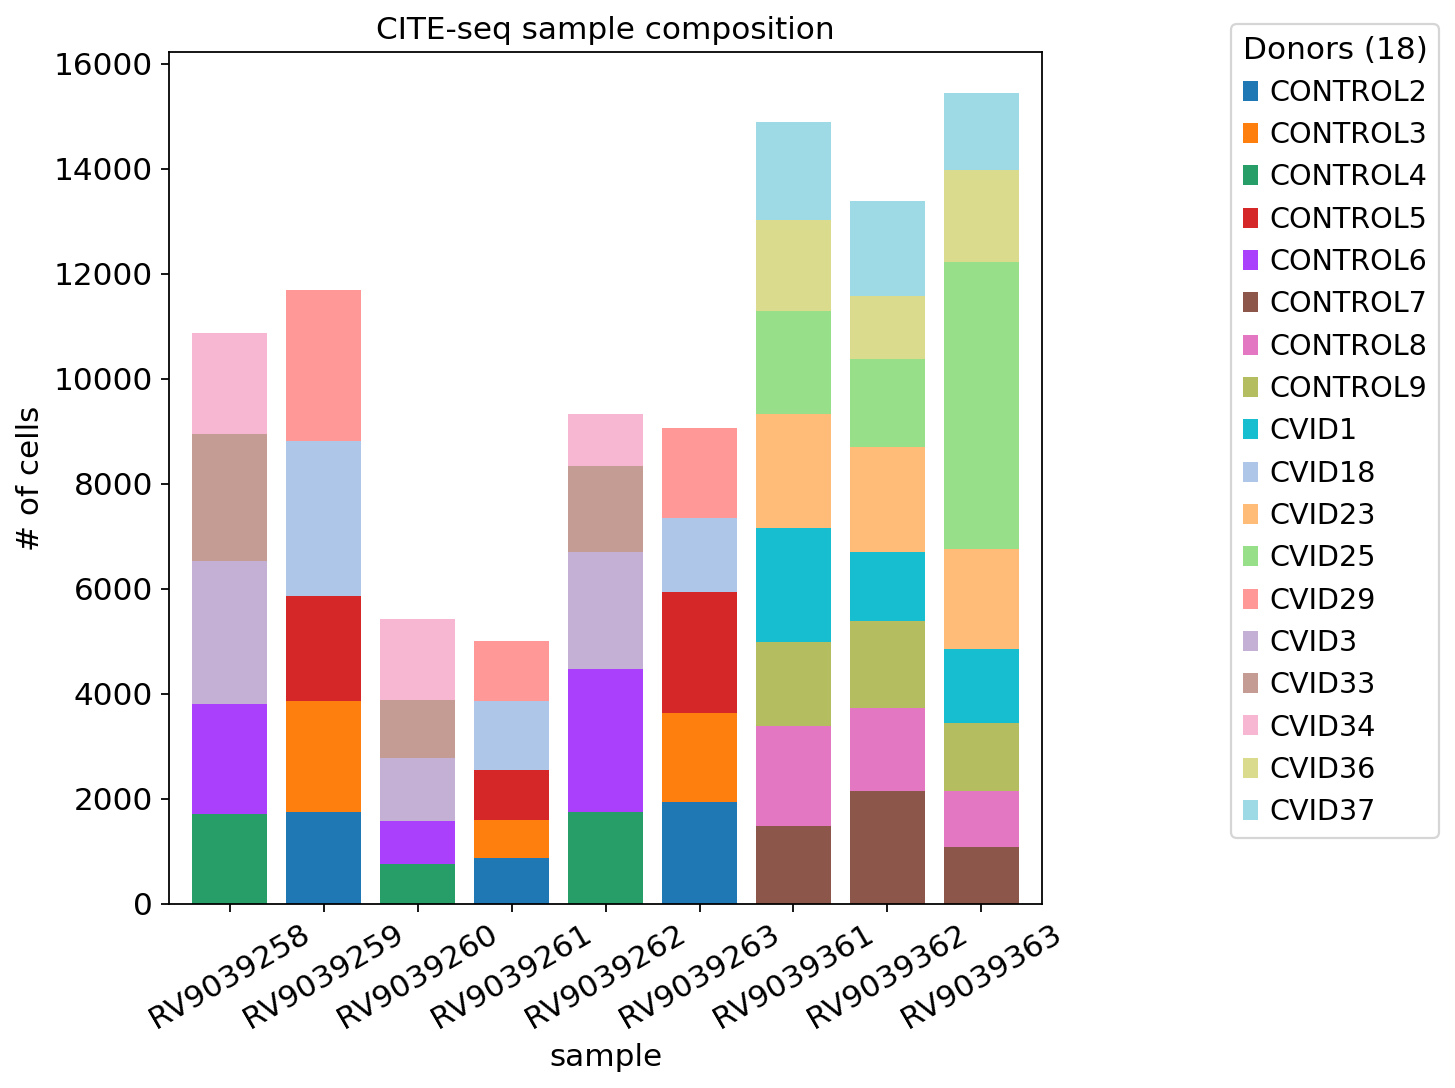

In [103]:
# this is for final cells only

ax = df_stats.plot.bar(stacked=True, figsize=(7,7), width=0.8)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles,
          labels, title='Donors (18)',
          bbox_to_anchor=(1.20, 1.05))

ax.set_xticklabels(labels=['RV9039258',
                           'RV9039259',
                           'RV9039260',
                           'RV9039261',
                           'RV9039262',
                           'RV9039263',
                           #'RV9039264',
                           #'RV9039265',
                           'RV9039361',
                           'RV9039362',
                           'RV9039363',
                           #'RV9039364',
                          ])
ax.tick_params(axis='x', rotation=30)

# to turn off the grid
plt.grid(b=None)

plt.title('CITE-seq sample composition')
plt.ylabel('# of cells')
plt.xlabel('sample')

plt.savefig('./figures/CITE-seq_sample_composition_all_samples_final_cells_20210217.pdf',
           bbox_inches='tight')

In [104]:
np.unique(adata_hvg.obs['cell_type'])

array(['B_cells_memory', 'B_cells_memory_activated', 'B_cells_naive',
       'B_cells_naive_activated', 'MAIT_cells', 'Macrophages',
       'Monocytes_classical', 'Monocytes_intermediate',
       'Monocytes_non-classical', 'NK_CD16_bright',
       'NK_CD16_bright_activated', 'NK_CD56_bright',
       'NK_CD56_bright_activated', 'Plasma_cells', 'Precursor_cells',
       'T4_activated', 'T4_memory', 'T4_naive', 'T8_activated',
       'T8_naive', 'TCM_CD8+', 'TEM_CD8+', 'TMRA_CD8+', 'T_gd', 'T_regs',
       'cDC1', 'cDC2', 'iNKT_cells', 'pDC'], dtype=object)

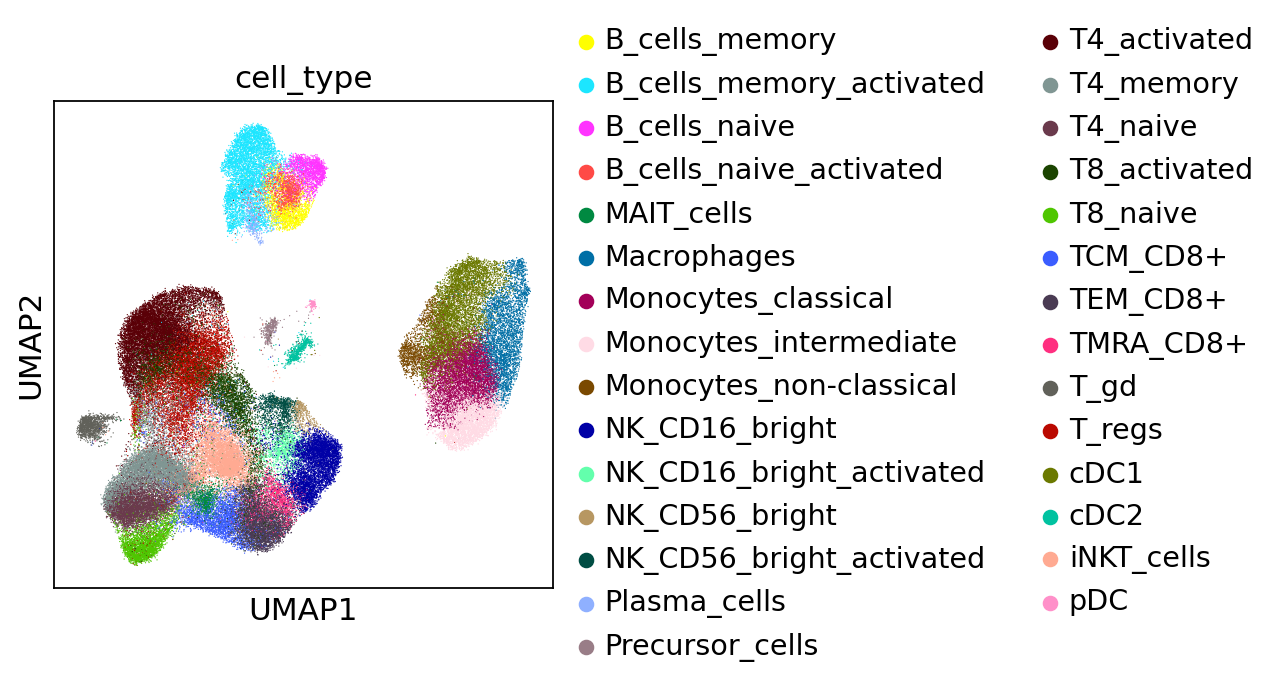

In [105]:
sc.pl.umap(adata_hvg, color=['cell_type'], 
           #palette=default_colormap[::-1]
          )

In [109]:
adata_hvg.uns.keys()

dict_keys(['log1p', 'hvg', 'pca', 'neighbors', 'umap', 'stimulation_colors', 'sample_colors', 'donor_colors', 'cell_type_colors', 'phase_colors'])

In [110]:
default_colormap = list(adata_hvg.uns['cell_type_colors'])

In [111]:
default_colormap


['#FFFF00',
 '#1CE6FF',
 '#FF34FF',
 '#FF4A46',
 '#008941',
 '#006FA6',
 '#A30059',
 '#FFDBE5',
 '#7A4900',
 '#0000A6',
 '#63FFAC',
 '#B79762',
 '#004D43',
 '#8FB0FF',
 '#997D87',
 '#5A0007',
 '#809693',
 '#6A3A4C',
 '#1B4400',
 '#4FC601',
 '#3B5DFF',
 '#4A3B53',
 '#FF2F80',
 '#61615A',
 '#BA0900',
 '#6B7900',
 '#00C2A0',
 '#FFAA92',
 '#FF90C9']

In [112]:
default_colormap_shuffled = default_colormap
np.random.shuffle(default_colormap_shuffled)

In [113]:
default_colormap_shuffled

['#3B5DFF',
 '#5A0007',
 '#4FC601',
 '#A30059',
 '#FFFF00',
 '#FFAA92',
 '#4A3B53',
 '#1B4400',
 '#61615A',
 '#FF34FF',
 '#FF4A46',
 '#8FB0FF',
 '#B79762',
 '#006FA6',
 '#1CE6FF',
 '#FF90C9',
 '#FFDBE5',
 '#008941',
 '#6B7900',
 '#6A3A4C',
 '#997D87',
 '#004D43',
 '#0000A6',
 '#7A4900',
 '#809693',
 '#00C2A0',
 '#BA0900',
 '#FF2F80',
 '#63FFAC']

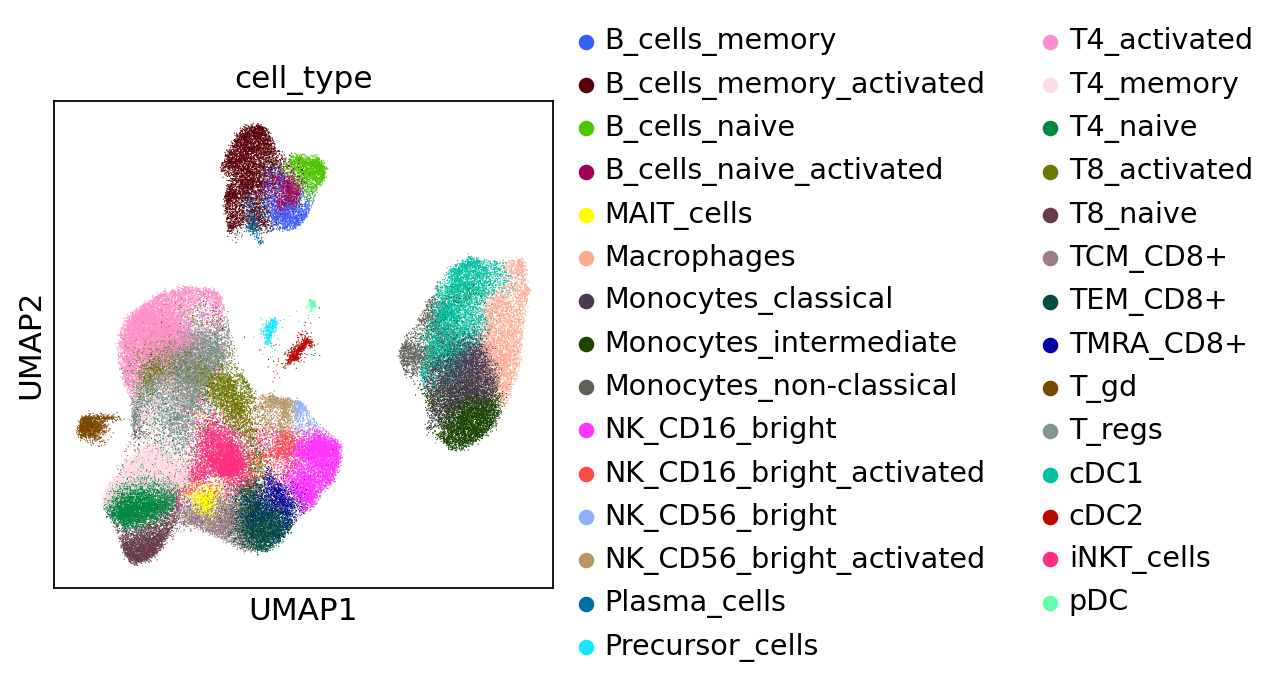

In [114]:
sc.pl.umap(adata_hvg, color=['cell_type'], palette=default_colormap_shuffled)

In [115]:
# adding GC-like B cell predictions
predictions = pd.read_csv(save_path + 'table_predictions_GC_B_cells_GEX_and_SoupX_denoised_protein_validation_cohort_20210215.csv', index_col=0)
predictions

GC_celltype_predictions_all_genes  \
index                                                    
AAACCTGAGAATGTGT-1                                 NaN   
AAACCTGAGACTAAGT-1                                 NaN   
AAACCTGAGCCGCCTA-1                                 NaN   
AAACCTGAGCGCCTCA-1                                 NaN   
AAACCTGAGGATGTAT-1                                 NaN   
...                                                ...   
TTTGTCATCCCTTGCA-1-1                               NaN   
TTTGTCATCCGCGTTT-1                          GC_B_cells   
TTTGTCATCGGAGGTA-1                       Other_B_cells   
TTTGTCATCGGCTACG-1-1                               NaN   
TTTGTCATCTTGGGTA-1                       Other_B_cells   

                      probabilities_GC_all_genes  
index                                             
AAACCTGAGAATGTGT-1                      0.000000  
AAACCTGAGACTAAGT-1                      0.000000  
AAACCTGAGCCGCCTA-1                      0.000000  
AAACCTGAGCGCCTCA-1                      0.000000  
AAACCTGAGGATGTAT-1                      0.000000  
...                                          ...  
TTTGTCATCCCTTGCA-1-1                    0.000000  
TTTGTCATCCGCGTTT-1                      0.622215  
TTTGTCATCGGAGGTA-1                      0.717948  
TTTGTCATCGGCTACG-1-1                    0.000000  
TTTGTCATCTTGGGTA-1                      0.710477  

[107050 rows x 2 columns]

In [116]:
for col in ['GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes']:
    adata_hvg.obs[col] = predictions.loc[adata_hvg.obs_names, col]

... storing 'GC_celltype_predictions_all_genes' as categorical


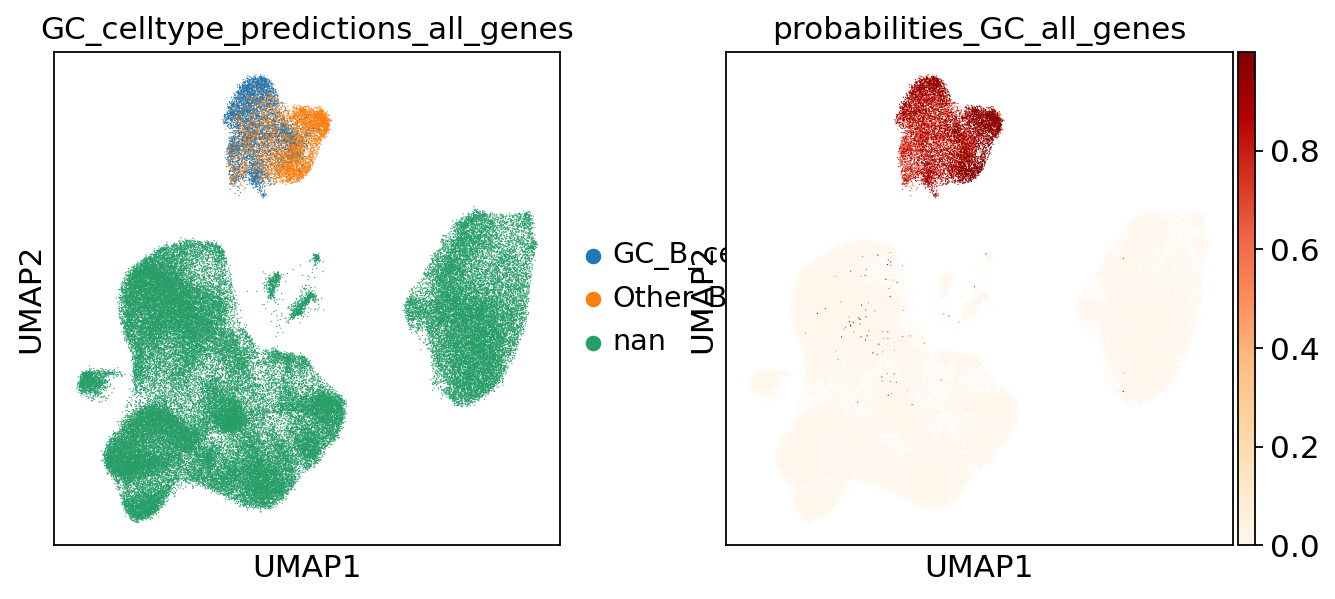

In [117]:
sc.pl.umap(adata_hvg, color=['GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'],
          cmap='OrRd')

In [118]:
adata_hvg.write(save_path + 'adata_hvg_bbknn_by_sample_validation_cohort_final_manifold_with_annotation_20210217.h5ad')

In [6]:
adata_hvg = sc.read(save_path + 'adata_hvg_bbknn_by_sample_validation_cohort_final_manifold_with_annotation_20210217.h5ad')

In [7]:
adata_hvg

AnnData object with n_obs × n_vars = 95064 × 2627
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4'

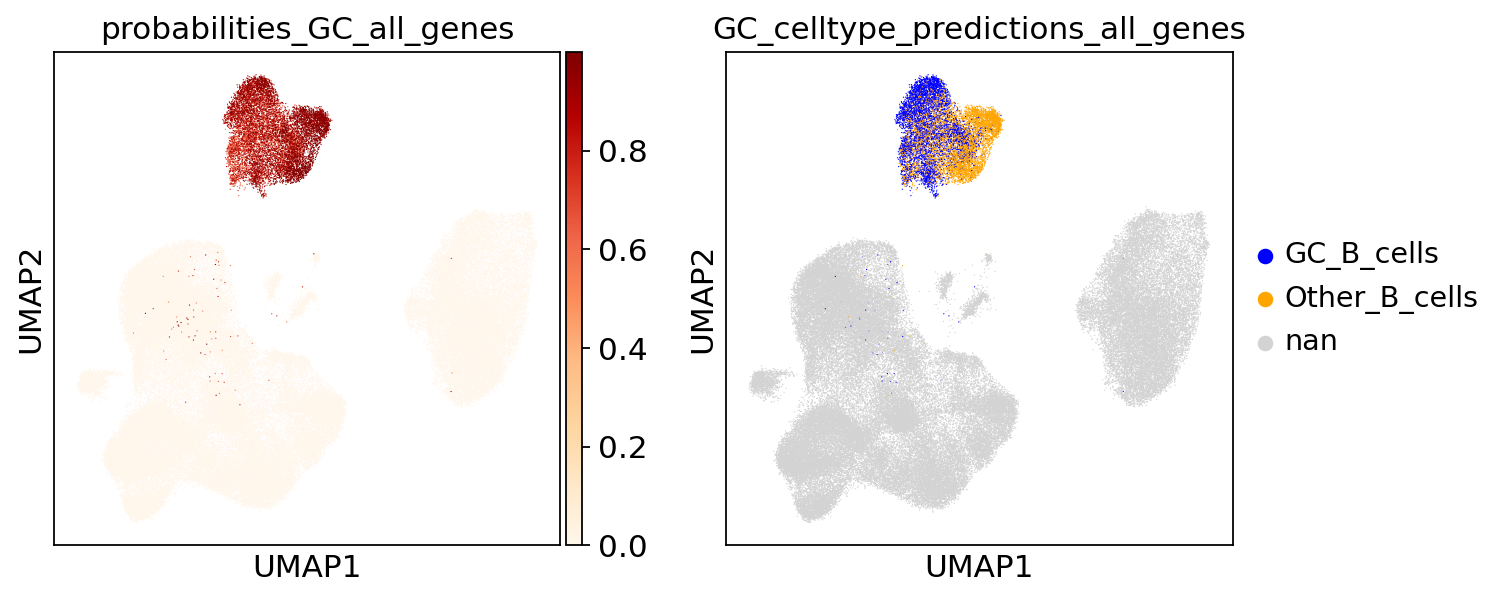

In [8]:
sc.pl.umap(adata_hvg, color=['probabilities_GC_all_genes', 'GC_celltype_predictions_all_genes'],
           palette=['blue','orange','lightgrey'],
          cmap='OrRd')

In [11]:
adata_hvg

AnnData object with n_obs × n_vars = 95064 × 2627
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4'

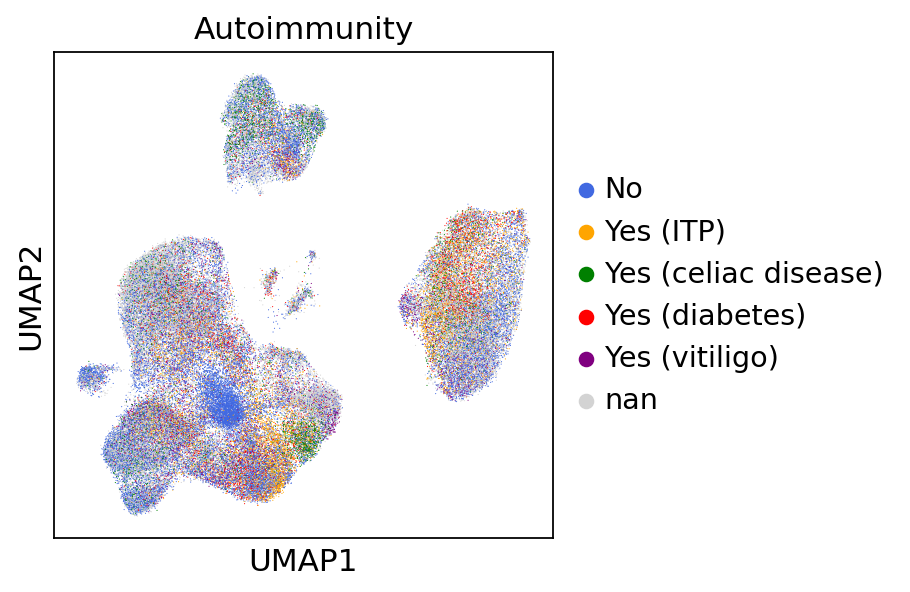

In [36]:
sc.pl.umap(adata_hvg, color=['Autoimmunity'],
          palette=['royalblue','orange','green','red','purple','lightgrey'],
          s=1)

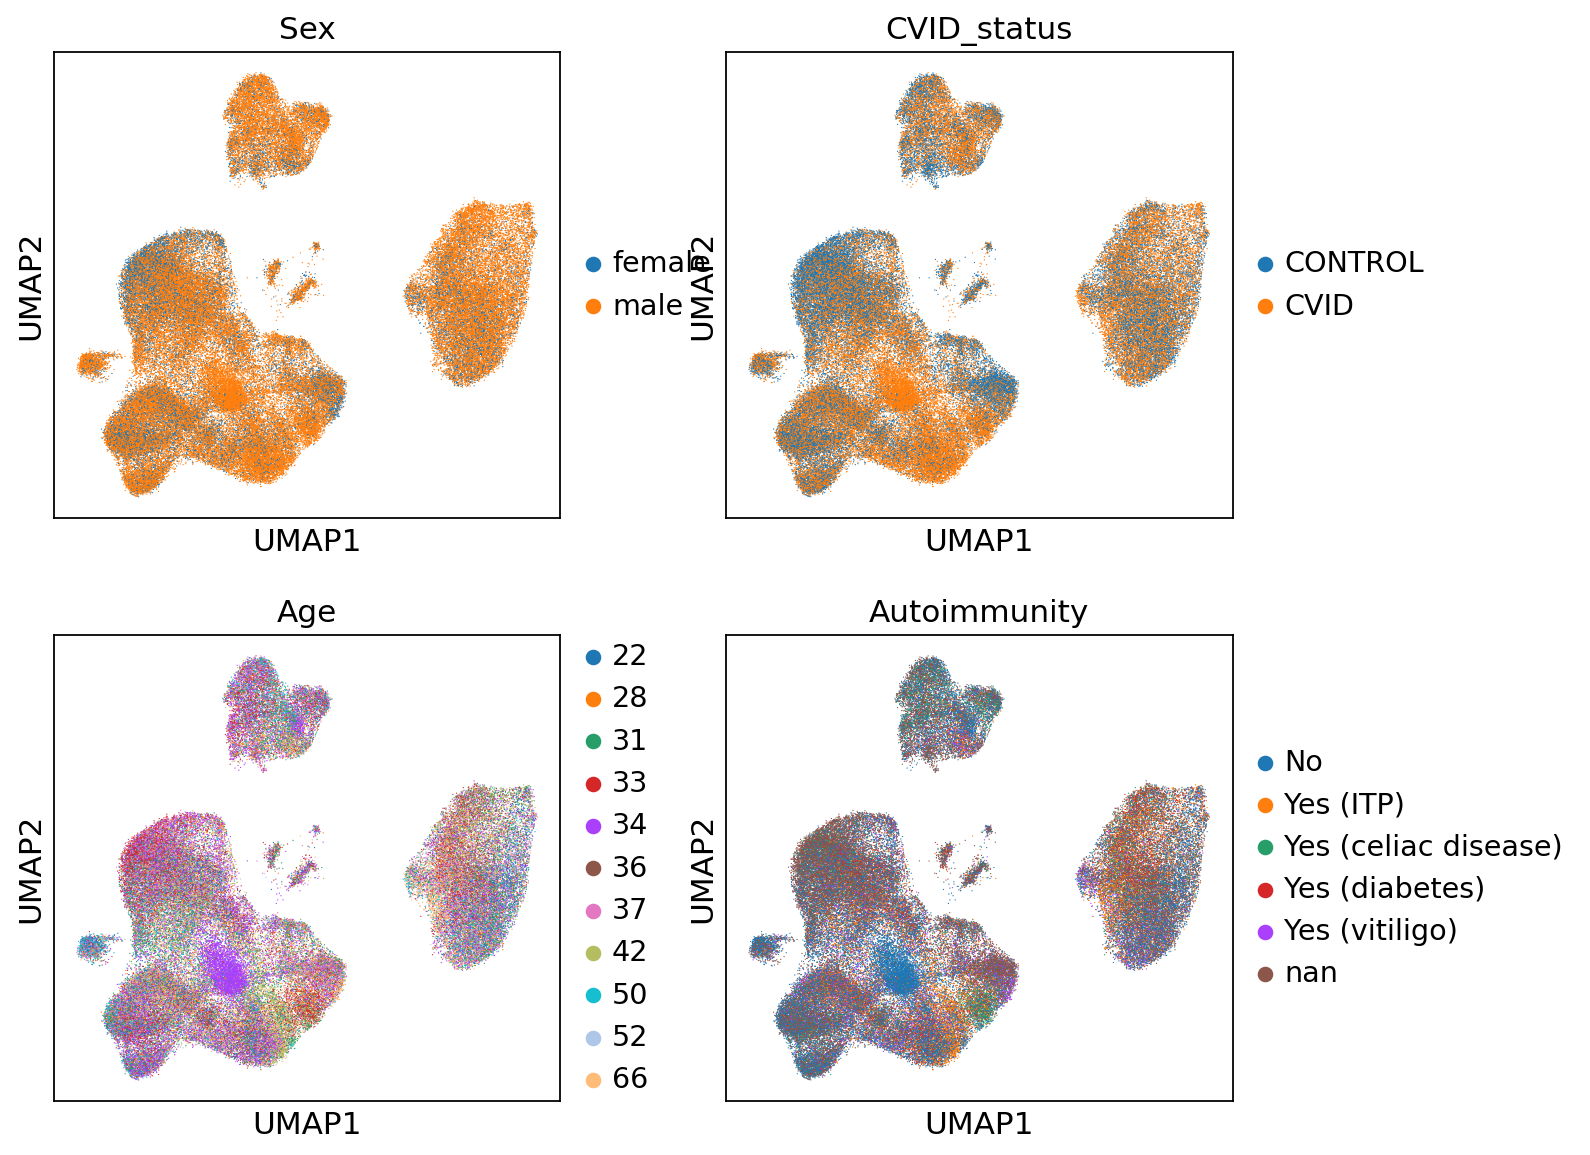

In [14]:
sc.pl.umap(adata_hvg, color=['Sex', 'CVID_status','Age','Autoimmunity'],
          ncols=2)

In [7]:
adata_hvg.obs.columns

Index(['batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes',
       'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score',
       'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type',
       'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score',
       'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm',
       'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset',
       'Autoimmunity', 'Gastrointestinal disease',
       'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly',
       'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members',
       'CVID_status', 'GC_celltype_predictions_all_genes',
       'probabilities_GC_all_genes'],
      dtype='object')

In [9]:
n_males = 0

n_females = 0

for donor in np.unique(adata_hvg.obs['donor']):
    print('donor', donor)
    curr_donor_gender = np.unique(adata_hvg[adata_hvg.obs['donor'] == donor].obs['Sex'])
    print('gender:', curr_donor_gender, '\n')
    
    if curr_donor_gender == ['male']:
        n_males += 1
    elif curr_donor_gender == ['female']:
        n_females += 1

donor CONTROL2
gender: ['male'] 

donor CONTROL3
gender: ['male'] 

donor CONTROL4
gender: ['male'] 

donor CONTROL5
gender: ['female'] 

donor CONTROL6
gender: ['female'] 

donor CONTROL7
gender: ['male'] 

donor CONTROL8
gender: ['male'] 

donor CONTROL9
gender: ['female'] 

donor CVID1
gender: ['female'] 

donor CVID18
gender: ['male'] 

donor CVID23
gender: ['male'] 

donor CVID25
gender: ['male'] 

donor CVID29
gender: ['male'] 

donor CVID3
gender: ['male'] 

donor CVID33
gender: ['male'] 

donor CVID34
gender: ['male'] 

donor CVID36
gender: ['male'] 

donor CVID37
gender: ['male'] 



In [10]:
n_males

14

In [12]:
n_females

4

### Producing a plot of the cell type distribution per donor

In [15]:
np.unique(adata_hvg.obs['cell_type'])

array(['B_cells_memory', 'B_cells_memory_activated', 'B_cells_naive',
       'B_cells_naive_activated', 'MAIT_cells', 'Macrophages',
       'Monocytes_classical', 'Monocytes_intermediate',
       'Monocytes_non-classical', 'NK_CD16_bright',
       'NK_CD16_bright_activated', 'NK_CD56_bright',
       'NK_CD56_bright_activated', 'Plasma_cells', 'Precursor_cells',
       'T4_activated', 'T4_memory', 'T4_naive', 'T8_activated',
       'T8_naive', 'TCM_CD8+', 'TEM_CD8+', 'TMRA_CD8+', 'T_gd', 'T_regs',
       'cDC1', 'cDC2', 'iNKT_cells', 'pDC'], dtype=object)

In [17]:
adata_hvg.obs['celltype_donor'] = [i + '_' + j for i,j in zip(adata_hvg.obs['cell_type'],
                                                              adata_hvg.obs['donor'])]

In [19]:
np.unique(adata_hvg.obs['celltype_donor'])

array(['B_cells_memory_CONTROL2', 'B_cells_memory_CONTROL3',
       'B_cells_memory_CONTROL4', 'B_cells_memory_CONTROL5',
       'B_cells_memory_CONTROL6', 'B_cells_memory_CONTROL7',
       'B_cells_memory_CONTROL8', 'B_cells_memory_CONTROL9',
       'B_cells_memory_CVID1', 'B_cells_memory_CVID18',
       'B_cells_memory_CVID23', 'B_cells_memory_CVID25',
       'B_cells_memory_CVID29', 'B_cells_memory_CVID3',
       'B_cells_memory_CVID33', 'B_cells_memory_CVID34',
       'B_cells_memory_CVID36', 'B_cells_memory_CVID37',
       'B_cells_memory_activated_CONTROL2',
       'B_cells_memory_activated_CONTROL3',
       'B_cells_memory_activated_CONTROL4',
       'B_cells_memory_activated_CONTROL5',
       'B_cells_memory_activated_CONTROL6',
       'B_cells_memory_activated_CONTROL7',
       'B_cells_memory_activated_CONTROL8',
       'B_cells_memory_activated_CONTROL9',
       'B_cells_memory_activated_CVID1',
       'B_cells_memory_activated_CVID18',
       'B_cells_memory_activated_CVID2

In [20]:
df_cell_type_by_donor = pd.DataFrame(columns=list(np.unique(adata_hvg.obs['donor'])),
                     index=list(np.unique(adata_hvg.obs['cell_type'])))

In [21]:
df_cell_type_by_donor

CONTROL2 CONTROL3 CONTROL4 CONTROL5 CONTROL6  \
B_cells_memory                NaN      NaN      NaN      NaN      NaN   
B_cells_memory_activated      NaN      NaN      NaN      NaN      NaN   
B_cells_naive                 NaN      NaN      NaN      NaN      NaN   
B_cells_naive_activated       NaN      NaN      NaN      NaN      NaN   
MAIT_cells                    NaN      NaN      NaN      NaN      NaN   
Macrophages                   NaN      NaN      NaN      NaN      NaN   
Monocytes_classical           NaN      NaN      NaN      NaN      NaN   
Monocytes_intermediate        NaN      NaN      NaN      NaN      NaN   
Monocytes_non-classical       NaN      NaN      NaN      NaN      NaN   
NK_CD16_bright                NaN      NaN      NaN      NaN      NaN   
NK_CD16_bright_activated      NaN      NaN      NaN      NaN      NaN   
NK_CD56_bright                NaN      NaN      NaN      NaN      NaN   
NK_CD56_bright_activated      NaN      NaN      NaN      NaN      NaN   
Plasma_cells                  NaN      NaN      NaN      NaN      NaN   
Precursor_cells               NaN      NaN      NaN      NaN      NaN   
T4_activated                  NaN      NaN      NaN      NaN      NaN   
T4_memory                     NaN      NaN      NaN      NaN      NaN   
T4_naive                      NaN      NaN      NaN      NaN      NaN   
T8_activated                  NaN      NaN      NaN      NaN      NaN   
T8_naive                      NaN      NaN      NaN      NaN      NaN   
TCM_CD8+                      NaN      NaN      NaN      NaN      NaN   
TEM_CD8+                      NaN      NaN      NaN      NaN      NaN   
TMRA_CD8+                     NaN      NaN      NaN      NaN      NaN   
T_gd                          NaN      NaN      NaN      NaN      NaN   
T_regs                        NaN      NaN      NaN      NaN      NaN   
cDC1                          NaN      NaN      NaN      NaN      NaN   
cDC2                          NaN      NaN      NaN      NaN      NaN   
iNKT_cells                    NaN      NaN      NaN      NaN      NaN   
pDC                           NaN      NaN      NaN      NaN      NaN   

                         CONTROL7 CONTROL8 CONTROL9 CVID1 CVID18 CVID23  \
B_cells_memory                NaN      NaN      NaN   NaN    NaN    NaN   
B_cells_memory_activated      NaN      NaN      NaN   NaN    NaN    NaN   
B_cells_naive                 NaN      NaN      NaN   NaN    NaN    NaN   
B_cells_naive_activated       NaN      NaN      NaN   NaN    NaN    NaN   
MAIT_cells                    NaN      NaN      NaN   NaN    NaN    NaN   
Macrophages                   NaN      NaN      NaN   NaN    NaN    NaN   
Monocytes_classical           NaN      NaN      NaN   NaN    NaN    NaN   
Monocytes_intermediate        NaN      NaN      NaN   NaN    NaN    NaN   
Monocytes_non-classical       NaN      NaN      NaN   NaN    NaN    NaN   
NK_CD16_bright                NaN      NaN      NaN   NaN    NaN    NaN   
NK_CD16_bright_activated      NaN      NaN      NaN   NaN    NaN    NaN   
NK_CD56_bright                NaN      NaN      NaN   NaN    NaN    NaN   
NK_CD56_bright_activated      NaN      NaN      NaN   NaN    NaN    NaN   
Plasma_cells                  NaN      NaN      NaN   NaN    NaN    NaN   
Precursor_cells               NaN      NaN      NaN   NaN    NaN    NaN   
T4_activated                  NaN      NaN      NaN   NaN    NaN    NaN   
T4_memory                     NaN      NaN      NaN   NaN    NaN    NaN   
T4_naive                      NaN      NaN      NaN   NaN    NaN    NaN   
T8_activated                  NaN      NaN      NaN   NaN    NaN    NaN   
T8_naive                      NaN      NaN      NaN   NaN    NaN    NaN   
TCM_CD8+                      NaN      NaN      NaN   NaN    NaN    NaN   
TEM_CD8+                      NaN      NaN      NaN   NaN    NaN    NaN   
TMRA_CD8+                     NaN      NaN      NaN   NaN    NaN    NaN   
T_gd                          NaN 

In [22]:
for donor in df_cell_type_by_donor.columns:
    print('donor', donor)
    for celltype in df_cell_type_by_donor.index:
        #print(sample)
        df_cell_type_by_donor.loc[celltype, donor] = adata_hvg[(adata_hvg.obs['cell_type'] == celltype)
                                         & (adata_hvg.obs['donor'] == donor)].X.shape[0]

donor CONTROL2
donor CONTROL3
donor CONTROL4
donor CONTROL5
donor CONTROL6
donor CONTROL7
donor CONTROL8
donor CONTROL9
donor CVID1
donor CVID18
donor CVID23
donor CVID25
donor CVID29
donor CVID3
donor CVID33
donor CVID34
donor CVID36
donor CVID37


In [24]:
df_cell_type_by_donor = df_cell_type_by_donor.T

In [25]:
df_cell_type_by_donor

B_cells_memory  B_cells_memory_activated  B_cells_naive  \
CONTROL2              48                       341             69   
CONTROL3              31                       278            120   
CONTROL4              46                       212             44   
CONTROL5              40                       344            128   
CONTROL6              31                       173             21   
CONTROL7             103                       440             94   
CONTROL8             106                       265            102   
CONTROL9             101                       268             47   
CVID1                164                        60             27   
CVID18                84                       770            345   
CVID23               123                       597            222   
CVID25               155                       279            105   
CVID29                36                       233             80   
CVID3                 60                       518             91   
CVID33                69                       246             51   
CVID34                40                        43             20   
CVID36               137                       144             81   
CVID37               164                        79             47   

          B_cells_naive_activated  MAIT_cells  Macrophages  \
CONTROL2                        7          23          198   
CONTROL3                       22          36          197   
CONTROL4                       11          46          129   
CONTROL5                       19          58          236   
CONTROL6                        8         128           93   
CONTROL7                       85          56          194   
CONTROL8                      155          59          284   
CONTROL9                       81         120          114   
CVID1                          68          40           92   
CVID18                         67          55           91   
CVID23                        191          21          256   
CVID25                        309          79          194   
CVID29                         16         184          651   
CVID3                          22          51          202   
CVID33                         17          77          123   
CVID34                          6          32          199   
CVID36                        104          49          240   
CVID37                         88          59          311   

          Monocytes_classical  Monocytes_intermediate  \
CONTROL2                  105                      51   
CONTROL3                  355                     105   
CONTROL4                  320                     135   
CONTROL5                  335                     100   
CONTROL6                  368                     198   
CONTROL7                  271                     334   
CONTROL8                  417                     571   
CONTROL9                  187                     258   
CVID1                     192                     449   
CVID18                    397                      88   
CVID23                    387                     407   
CVID25                    462                     576   
CVID29                    441                     231   
CVID3                     106                      80   
CVID33                    331                      62   
CVID34                    512                     193   
CVID36                     79                      68   
CVID37                    209                     297   

          Monocytes_non-classical  NK_CD16_bright  ...  T8_naive  TCM_CD8+  \
CONTROL2                       62             181  ...       143        97   
CONTROL3                       71             209  ...       212       124   
CONTROL4                      126             338  ...       107       130   
CONTROL5                       67             224  ...        99        73   
CONTROL6                       34            

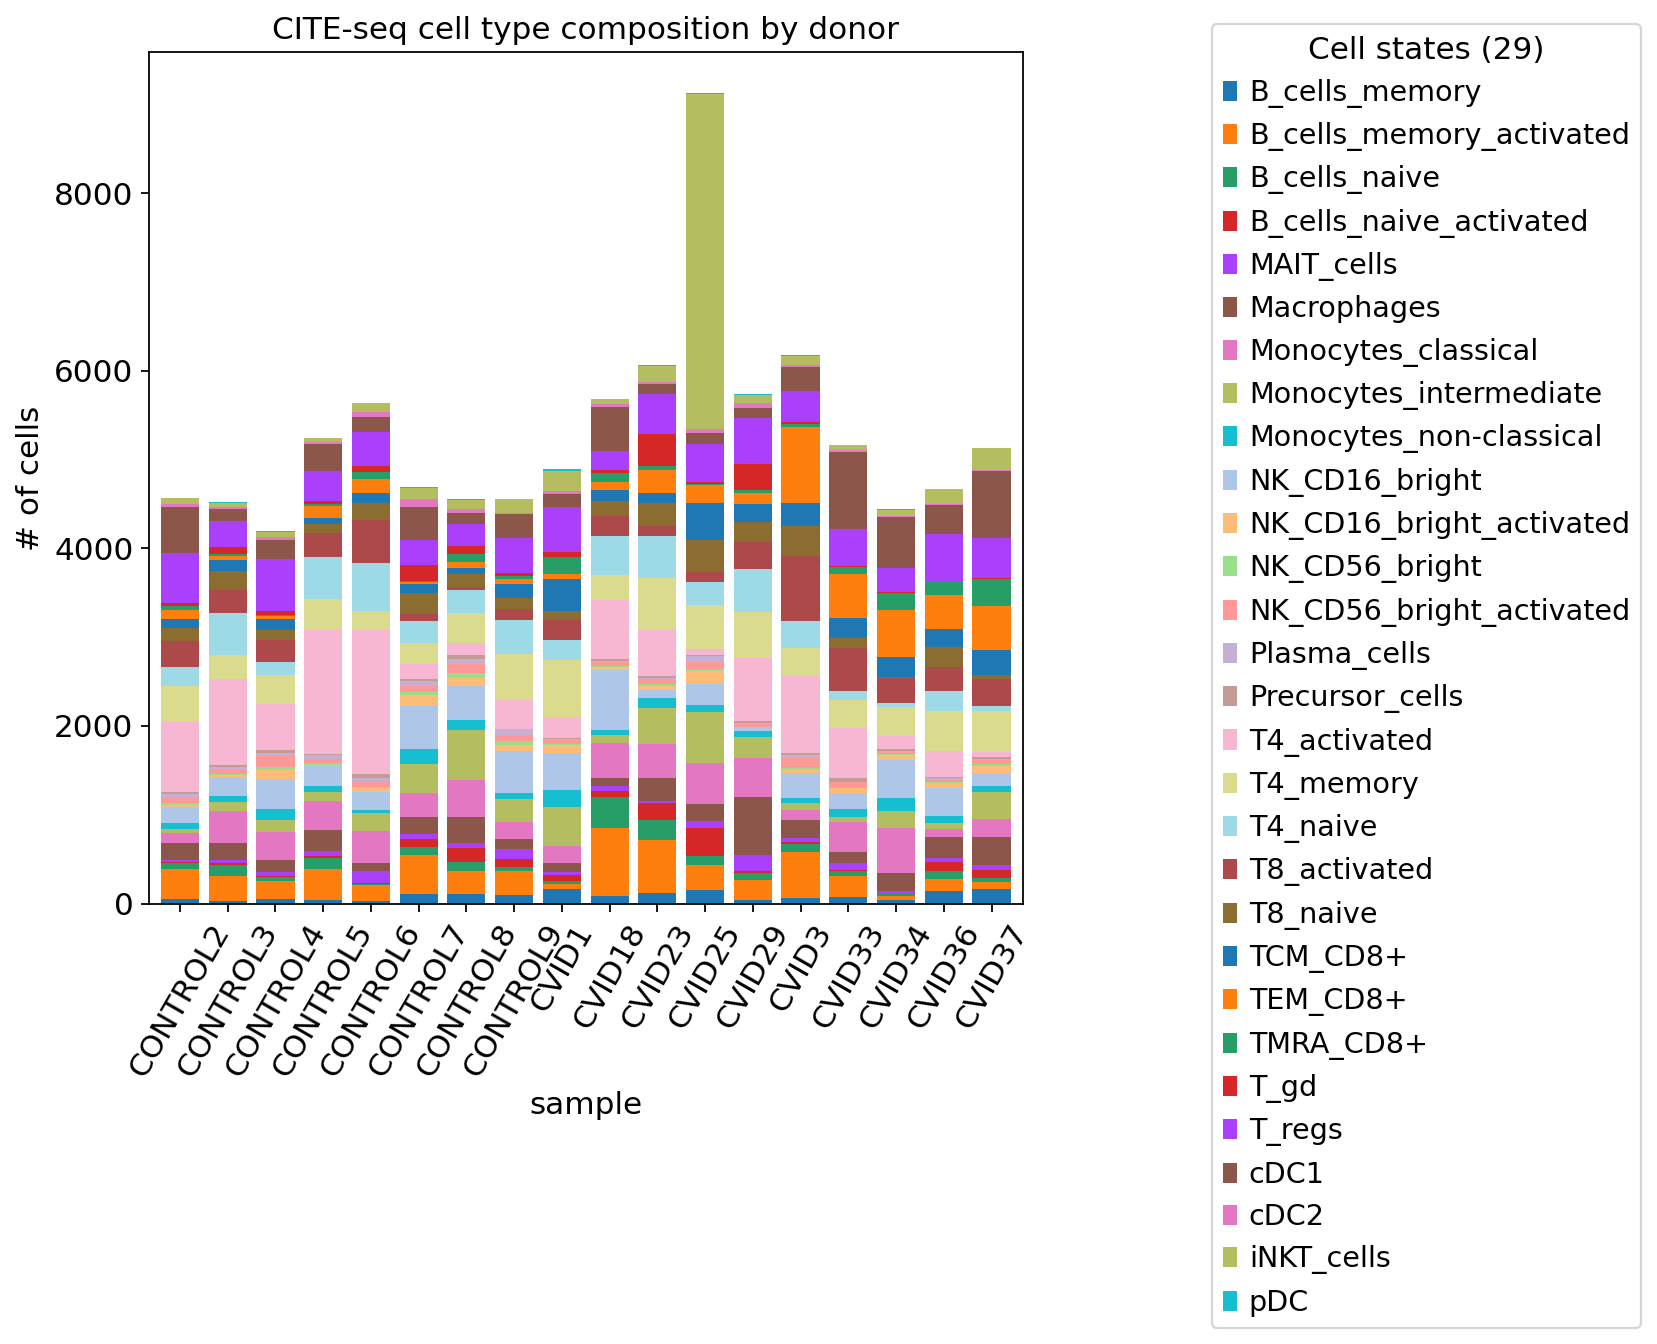

In [28]:
# this is for final cells only

ax = df_cell_type_by_donor.plot.bar(stacked=True, figsize=(7,7), width=0.8)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles,
          labels, title='Cell states (29)',
          bbox_to_anchor=(1.20, 1.05))

ax.set_xticklabels(labels=list(df_cell_type_by_donor.index))
ax.tick_params(axis='x', rotation=60)

# to turn off the grid
plt.grid(b=None)

plt.title('CITE-seq cell type composition by donor')
plt.ylabel('# of cells')
plt.xlabel('sample')

plt.savefig('./figures/CITE-seq_cell_type_composition_by_donor_validation_cohort_20210218.pdf',
           bbox_inches='tight')

### Producing a plot of the number of B cells in each cell cycle phase per (a) activation; (b) CIVD/CONTROL status and (c) Naive/memory/plasma compartments

In [119]:
np.unique(adata_hvg.obs['cell_type'])

array(['B_cells_memory', 'B_cells_memory_activated', 'B_cells_naive',
       'B_cells_naive_activated', 'MAIT_cells', 'Macrophages',
       'Monocytes_classical', 'Monocytes_intermediate',
       'Monocytes_non-classical', 'NK_CD16_bright',
       'NK_CD16_bright_activated', 'NK_CD56_bright',
       'NK_CD56_bright_activated', 'Plasma_cells', 'Precursor_cells',
       'T4_activated', 'T4_memory', 'T4_naive', 'T8_activated',
       'T8_naive', 'TCM_CD8+', 'TEM_CD8+', 'TMRA_CD8+', 'T_gd', 'T_regs',
       'cDC1', 'cDC2', 'iNKT_cells', 'pDC'], dtype=object)

In [120]:
# all B cells except Plasma cells
adata_hvg_B_cell_compartment = adata_hvg[adata_hvg.obs['cell_type'].isin(['B_cells_memory', 'B_cells_memory_activated',
                                                                          'B_cells_naive','B_cells_naive_activated'])].copy()

I need to generate tables of number of celltypes by the following keys:
- celltype_condition
- stimulation_celltype_condition
- GC_phenotype_celltype_condition

In [121]:
adata_hvg_B_cell_compartment.obs['celltype_condition'] = [i + '_' + j for i,j in zip(adata_hvg_B_cell_compartment.obs['cell_type'], 
                                                                                                adata_hvg_B_cell_compartment.obs['CVID_status'])]

In [122]:
np.unique(adata_hvg_B_cell_compartment.obs['celltype_condition'])

array(['B_cells_memory_CONTROL', 'B_cells_memory_CVID',
       'B_cells_memory_activated_CONTROL',
       'B_cells_memory_activated_CVID', 'B_cells_naive_CONTROL',
       'B_cells_naive_CVID', 'B_cells_naive_activated_CONTROL',
       'B_cells_naive_activated_CVID'], dtype=object)

In [123]:
adata_hvg_B_cell_compartment.obs['stimulation_celltype_condition'] = [i + '_' + j for i,j in zip(adata_hvg_B_cell_compartment.obs['stimulation'], 
                                                                                                adata_hvg_B_cell_compartment.obs['celltype_condition'])]

In [124]:
np.unique(adata_hvg_B_cell_compartment.obs['stimulation_celltype_condition'])

array(['CD3_B_cells_memory_CONTROL', 'CD3_B_cells_memory_CVID',
       'CD3_B_cells_memory_activated_CONTROL',
       'CD3_B_cells_memory_activated_CVID', 'CD3_B_cells_naive_CONTROL',
       'CD3_B_cells_naive_CVID', 'CD3_B_cells_naive_activated_CONTROL',
       'CD3_B_cells_naive_activated_CVID', 'CD40L_B_cells_memory_CONTROL',
       'CD40L_B_cells_memory_CVID',
       'CD40L_B_cells_memory_activated_CONTROL',
       'CD40L_B_cells_memory_activated_CVID',
       'CD40L_B_cells_naive_CONTROL', 'CD40L_B_cells_naive_CVID',
       'CD40L_B_cells_naive_activated_CONTROL',
       'CD40L_B_cells_naive_activated_CVID',
       'unstim_B_cells_memory_CONTROL', 'unstim_B_cells_memory_CVID',
       'unstim_B_cells_memory_activated_CONTROL',
       'unstim_B_cells_memory_activated_CVID',
       'unstim_B_cells_naive_CONTROL', 'unstim_B_cells_naive_CVID',
       'unstim_B_cells_naive_activated_CONTROL',
       'unstim_B_cells_naive_activated_CVID'], dtype=object)

In [125]:
adata_hvg_B_cell_compartment.obs['GC_phenotype_celltype_condition'] = [i + '_' + j for i,j in zip(adata_hvg_B_cell_compartment.obs['GC_celltype_predictions_all_genes'], 
                                                                                                adata_hvg_B_cell_compartment.obs['celltype_condition'])]

In [126]:
np.unique(adata_hvg_B_cell_compartment.obs['GC_phenotype_celltype_condition'])

array(['GC_B_cells_B_cells_memory_CONTROL',
       'GC_B_cells_B_cells_memory_CVID',
       'GC_B_cells_B_cells_memory_activated_CONTROL',
       'GC_B_cells_B_cells_memory_activated_CVID',
       'GC_B_cells_B_cells_naive_CONTROL',
       'GC_B_cells_B_cells_naive_CVID',
       'GC_B_cells_B_cells_naive_activated_CONTROL',
       'GC_B_cells_B_cells_naive_activated_CVID',
       'Other_B_cells_B_cells_memory_CONTROL',
       'Other_B_cells_B_cells_memory_CVID',
       'Other_B_cells_B_cells_memory_activated_CONTROL',
       'Other_B_cells_B_cells_memory_activated_CVID',
       'Other_B_cells_B_cells_naive_CONTROL',
       'Other_B_cells_B_cells_naive_CVID',
       'Other_B_cells_B_cells_naive_activated_CONTROL',
       'Other_B_cells_B_cells_naive_activated_CVID'], dtype=object)

In [127]:
df_stats_phase_by_celltype_condition = pd.DataFrame(columns=list(np.unique(adata_hvg_B_cell_compartment.obs['phase'])),
                     index=list(np.unique(adata_hvg_B_cell_compartment.obs['celltype_condition'])))

In [128]:
df_stats_phase_by_celltype_condition

G1  G2M    S
B_cells_memory_CONTROL            NaN  NaN  NaN
B_cells_memory_CVID               NaN  NaN  NaN
B_cells_memory_activated_CONTROL  NaN  NaN  NaN
B_cells_memory_activated_CVID     NaN  NaN  NaN
B_cells_naive_CONTROL             NaN  NaN  NaN
B_cells_naive_CVID                NaN  NaN  NaN
B_cells_naive_activated_CONTROL   NaN  NaN  NaN
B_cells_naive_activated_CVID      NaN  NaN  NaN

In [129]:
for phase in df_stats_phase_by_celltype_condition.columns:
    print('phase', phase)
    for key in df_stats_phase_by_celltype_condition.index:
        #print(sample)
        df_stats_phase_by_celltype_condition.loc[key, phase] = adata_hvg_B_cell_compartment[(adata_hvg_B_cell_compartment.obs['celltype_condition'] == key)
                                         & (adata_hvg_B_cell_compartment.obs['phase'] == phase)].X.shape[0]

phase G1
phase G2M
phase S


In [130]:
df_stats_phase_by_celltype_condition

G1  G2M     S
B_cells_memory_CONTROL            380   37    89
B_cells_memory_CVID               783  104   145
B_cells_memory_activated_CONTROL  439  448  1434
B_cells_memory_activated_CVID     653  592  1724
B_cells_naive_CONTROL             582   16    27
B_cells_naive_CVID                956   52    61
B_cells_naive_activated_CONTROL   176  126    86
B_cells_naive_activated_CVID      354  308   226

In [131]:
df_stats_phase_by_stimulation_celltype_condition = pd.DataFrame(columns=list(np.unique(adata_hvg_B_cell_compartment.obs['phase'])),
                     index=list(np.unique(adata_hvg_B_cell_compartment.obs['stimulation_celltype_condition'])))

In [132]:
df_stats_phase_by_stimulation_celltype_condition

G1  G2M    S
CD3_B_cells_memory_CONTROL               NaN  NaN  NaN
CD3_B_cells_memory_CVID                  NaN  NaN  NaN
CD3_B_cells_memory_activated_CONTROL     NaN  NaN  NaN
CD3_B_cells_memory_activated_CVID        NaN  NaN  NaN
CD3_B_cells_naive_CONTROL                NaN  NaN  NaN
CD3_B_cells_naive_CVID                   NaN  NaN  NaN
CD3_B_cells_naive_activated_CONTROL      NaN  NaN  NaN
CD3_B_cells_naive_activated_CVID         NaN  NaN  NaN
CD40L_B_cells_memory_CONTROL             NaN  NaN  NaN
CD40L_B_cells_memory_CVID                NaN  NaN  NaN
CD40L_B_cells_memory_activated_CONTROL   NaN  NaN  NaN
CD40L_B_cells_memory_activated_CVID      NaN  NaN  NaN
CD40L_B_cells_naive_CONTROL              NaN  NaN  NaN
CD40L_B_cells_naive_CVID                 NaN  NaN  NaN
CD40L_B_cells_naive_activated_CONTROL    NaN  NaN  NaN
CD40L_B_cells_naive_activated_CVID       NaN  NaN  NaN
unstim_B_cells_memory_CONTROL            NaN  NaN  NaN
unstim_B_cells_memory_CVID               NaN  NaN  NaN
unstim_B_cells_memory_activated_CONTROL  NaN  NaN  NaN
unstim_B_cells_memory_activated_CVID     NaN  NaN  NaN
unstim_B_cells_naive_CONTROL             NaN  NaN  NaN
unstim_B_cells_naive_CVID                NaN  NaN  NaN
unstim_B_cells_naive_activated_CONTROL   NaN  NaN  NaN
unstim_B_cells_naive_activated_CVID      NaN  NaN  NaN

In [133]:
for phase in df_stats_phase_by_stimulation_celltype_condition.columns:
    print('phase', phase)
    for key in df_stats_phase_by_stimulation_celltype_condition.index:
        #print(key)
        df_stats_phase_by_stimulation_celltype_condition.loc[key, phase] = adata_hvg_B_cell_compartment[(adata_hvg_B_cell_compartment.obs['stimulation_celltype_condition'] == key)
                                         & (adata_hvg_B_cell_compartment.obs['phase'] == phase)].X.shape[0]

phase G1
phase G2M
phase S


In [134]:
df_stats_phase_by_stimulation_celltype_condition

G1  G2M     S
CD3_B_cells_memory_CONTROL                26   14    24
CD3_B_cells_memory_CVID                   73   70    55
CD3_B_cells_memory_activated_CONTROL      76  197   337
CD3_B_cells_memory_activated_CVID         92  233   488
CD3_B_cells_naive_CONTROL                  6    7     2
CD3_B_cells_naive_CVID                    14   28    20
CD3_B_cells_naive_activated_CONTROL      109  120    79
CD3_B_cells_naive_activated_CVID         227  294   204
CD40L_B_cells_memory_CONTROL              82   19    58
CD40L_B_cells_memory_CVID                274   30    76
CD40L_B_cells_memory_activated_CONTROL   286  251  1092
CD40L_B_cells_memory_activated_CVID      478  357  1233
CD40L_B_cells_naive_CONTROL                6    2     8
CD40L_B_cells_naive_CVID                  61    6    10
CD40L_B_cells_naive_activated_CONTROL      6    4     3
CD40L_B_cells_naive_activated_CVID        31    9    17
unstim_B_cells_memory_CONTROL            272    4     7
unstim_B_cells_memory_CVID               436    4    14
unstim_B_cells_memory_activated_CONTROL   77    0     5
unstim_B_cells_memory_activated_CVID      83    2     3
unstim_B_cells_naive_CONTROL             570    7    17
unstim_B_cells_naive_CVID                881   18    31
unstim_B_cells_naive_activated_CONTROL    61    2     4
unstim_B_cells_naive_activated_CVID       96    5     5

In [135]:
df_stats_phase_by_GC_phenotype_celltype_condition = pd.DataFrame(columns=list(np.unique(adata_hvg_B_cell_compartment.obs['phase'])),
                     index=list(np.unique(adata_hvg_B_cell_compartment.obs['GC_phenotype_celltype_condition'])))

In [136]:
df_stats_phase_by_GC_phenotype_celltype_condition

G1  G2M    S
GC_B_cells_B_cells_memory_CONTROL               NaN  NaN  NaN
GC_B_cells_B_cells_memory_CVID                  NaN  NaN  NaN
GC_B_cells_B_cells_memory_activated_CONTROL     NaN  NaN  NaN
GC_B_cells_B_cells_memory_activated_CVID        NaN  NaN  NaN
GC_B_cells_B_cells_naive_CONTROL                NaN  NaN  NaN
GC_B_cells_B_cells_naive_CVID                   NaN  NaN  NaN
GC_B_cells_B_cells_naive_activated_CONTROL      NaN  NaN  NaN
GC_B_cells_B_cells_naive_activated_CVID         NaN  NaN  NaN
Other_B_cells_B_cells_memory_CONTROL            NaN  NaN  NaN
Other_B_cells_B_cells_memory_CVID               NaN  NaN  NaN
Other_B_cells_B_cells_memory_activated_CONTROL  NaN  NaN  NaN
Other_B_cells_B_cells_memory_activated_CVID     NaN  NaN  NaN
Other_B_cells_B_cells_naive_CONTROL             NaN  NaN  NaN
Other_B_cells_B_cells_naive_CVID                NaN  NaN  NaN
Other_B_cells_B_cells_naive_activated_CONTROL   NaN  NaN  NaN
Other_B_cells_B_cells_naive_activated_CVID      NaN  NaN  NaN

In [137]:
for phase in df_stats_phase_by_GC_phenotype_celltype_condition.columns:
    print('phase', phase)
    for key in df_stats_phase_by_GC_phenotype_celltype_condition.index:
        #print(key)
        df_stats_phase_by_GC_phenotype_celltype_condition.loc[key, phase] = adata_hvg_B_cell_compartment[(adata_hvg_B_cell_compartment.obs['GC_phenotype_celltype_condition'] == key)
                                         & (adata_hvg_B_cell_compartment.obs['phase'] == phase)].X.shape[0]

phase G1
phase G2M
phase S


In [138]:
df_stats_phase_by_GC_phenotype_celltype_condition

G1  G2M     S
GC_B_cells_B_cells_memory_CONTROL                34   23    72
GC_B_cells_B_cells_memory_CVID                   73   49    91
GC_B_cells_B_cells_memory_activated_CONTROL      97  344  1126
GC_B_cells_B_cells_memory_activated_CVID        116  466  1348
GC_B_cells_B_cells_naive_CONTROL                 18    6     9
GC_B_cells_B_cells_naive_CVID                    32   15    17
GC_B_cells_B_cells_naive_activated_CONTROL       51   61    46
GC_B_cells_B_cells_naive_activated_CVID          83  119   103
Other_B_cells_B_cells_memory_CONTROL            346   14    17
Other_B_cells_B_cells_memory_CVID               710   55    54
Other_B_cells_B_cells_memory_activated_CONTROL  342  104   308
Other_B_cells_B_cells_memory_activated_CVID     537  126   376
Other_B_cells_B_cells_naive_CONTROL             564   10    18
Other_B_cells_B_cells_naive_CVID                924   37    44
Other_B_cells_B_cells_naive_activated_CONTROL   125   65    40
Other_B_cells_B_cells_naive_activated_CVID      271  189   123

In [139]:
df_all_stats = pd.concat([df_stats_phase_by_celltype_condition, df_stats_phase_by_GC_phenotype_celltype_condition, df_stats_phase_by_stimulation_celltype_condition])

In [140]:
df_all_stats

G1  G2M     S
B_cells_memory_CONTROL                          380   37    89
B_cells_memory_CVID                             783  104   145
B_cells_memory_activated_CONTROL                439  448  1434
B_cells_memory_activated_CVID                   653  592  1724
B_cells_naive_CONTROL                           582   16    27
B_cells_naive_CVID                              956   52    61
B_cells_naive_activated_CONTROL                 176  126    86
B_cells_naive_activated_CVID                    354  308   226
GC_B_cells_B_cells_memory_CONTROL                34   23    72
GC_B_cells_B_cells_memory_CVID                   73   49    91
GC_B_cells_B_cells_memory_activated_CONTROL      97  344  1126
GC_B_cells_B_cells_memory_activated_CVID        116  466  1348
GC_B_cells_B_cells_naive_CONTROL                 18    6     9
GC_B_cells_B_cells_naive_CVID                    32   15    17
GC_B_cells_B_cells_naive_activated_CONTROL       51   61    46
GC_B_cells_B_cells_naive_activated_CVID          83  119   103
Other_B_cells_B_cells_memory_CONTROL            346   14    17
Other_B_cells_B_cells_memory_CVID               710   55    54
Other_B_cells_B_cells_memory_activated_CONTROL  342  104   308
Other_B_cells_B_cells_memory_activated_CVID     537  126   376
Other_B_cells_B_cells_naive_CONTROL             564   10    18
Other_B_cells_B_cells_naive_CVID                924   37    44
Other_B_cells_B_cells_naive_activated_CONTROL   125   65    40
Other_B_cells_B_cells_naive_activated_CVID      271  189   123
CD3_B_cells_memory_CONTROL                       26   14    24
CD3_B_cells_memory_CVID                          73   70    55
CD3_B_cells_memory_activated_CONTROL             76  197   337
CD3_B_cells_memory_activated_CVID                92  233   488
CD3_B_cells_naive_CONTROL                         6    7     2
CD3_B_cells_naive_CVID                           14   28    20
CD3_B_cells_naive_activated_CONTROL             109  120    79
CD3_B_cells_naive_activated_CVID                227  294   204
CD40L_B_cells_memory_CONTROL                     82   19    58
CD40L_B_cells_memory_CVID                       274   30    76
CD40L_B_cells_memory_activated_CONTROL          286  251  1092
CD40L_B_cells_memory_activated_CVID             478  357  1233
CD40L_B_cells_naive_CONTROL                       6    2     8
CD40L_B_cells_naive_CVID                         61    6    10
CD40L_B_cells_naive_activated_CONTROL             6    4     3
CD40L_B_cells_naive_activated_CVID               31    9    17
unstim_B_cells_memory_CONTROL                   272    4     7
unstim_B_cells_memory_CVID                      436    4    14
unstim_B_cells_memory_activated_CONTROL          77    0     5
unstim_B_cells_memory_activated_CVID             83    2     3
unstim_B_cells_naive_CONTROL                    570    7    17
unstim_B_cells_naive_CVID                       881   18    31
unstim_B_cells_naive_activated_CONTROL           61    2     4
unstim_B_cells_naive_activated_CVID              96    5     5

In [141]:
df_all_stats.to_csv('./B_cell_stats_phase_all_validation_cohort_20210217.csv')

### Producing a plot of the number of CD4+ T (T4) cells in each cell cycle phase per (a) activation and (b) CIVD/CONTROL status

In [7]:
np.unique(adata_hvg.obs['cell_type'])

array(['B_cells_memory', 'B_cells_memory_activated', 'B_cells_naive',
       'B_cells_naive_activated', 'MAIT_cells', 'Macrophages',
       'Monocytes_classical', 'Monocytes_intermediate',
       'Monocytes_non-classical', 'NK_CD16_bright',
       'NK_CD16_bright_activated', 'NK_CD56_bright',
       'NK_CD56_bright_activated', 'Plasma_cells', 'Precursor_cells',
       'T4_activated', 'T4_memory', 'T4_naive', 'T8_activated',
       'T8_naive', 'TCM_CD8+', 'TEM_CD8+', 'TMRA_CD8+', 'T_gd', 'T_regs',
       'cDC1', 'cDC2', 'iNKT_cells', 'pDC'], dtype=object)

In [8]:
# all B cells except Plasma cells
adata_hvg_T4_cell_compartment = adata_hvg[adata_hvg.obs['cell_type'].isin(['T4_activated', 'T4_memory', 'T4_naive'])].copy()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


I need to generate tables of number of celltypes by the following keys:
- celltype_condition
- stimulation_celltype_condition

In [9]:
adata_hvg_T4_cell_compartment.obs['celltype_condition'] = [i + '_' + j for i,j in zip(adata_hvg_T4_cell_compartment.obs['cell_type'], 
                                                                                                adata_hvg_T4_cell_compartment.obs['CVID_status'])]

In [10]:
np.unique(adata_hvg_T4_cell_compartment.obs['celltype_condition'])

array(['T4_activated_CONTROL', 'T4_activated_CVID', 'T4_memory_CONTROL',
       'T4_memory_CVID', 'T4_naive_CONTROL', 'T4_naive_CVID'],
      dtype=object)

In [11]:
adata_hvg_T4_cell_compartment.obs['stimulation_celltype_condition'] = [i + '_' + j for i,j in zip(adata_hvg_T4_cell_compartment.obs['stimulation'], 
                                                                                                adata_hvg_T4_cell_compartment.obs['celltype_condition'])]

In [12]:
np.unique(adata_hvg_T4_cell_compartment.obs['stimulation_celltype_condition'])

array(['CD3_T4_activated_CONTROL', 'CD3_T4_activated_CVID',
       'CD3_T4_memory_CONTROL', 'CD3_T4_memory_CVID',
       'CD3_T4_naive_CONTROL', 'CD3_T4_naive_CVID',
       'CD40L_T4_activated_CONTROL', 'CD40L_T4_activated_CVID',
       'CD40L_T4_memory_CONTROL', 'CD40L_T4_memory_CVID',
       'CD40L_T4_naive_CONTROL', 'CD40L_T4_naive_CVID',
       'unstim_T4_activated_CONTROL', 'unstim_T4_activated_CVID',
       'unstim_T4_memory_CONTROL', 'unstim_T4_memory_CVID',
       'unstim_T4_naive_CONTROL', 'unstim_T4_naive_CVID'], dtype=object)

In [13]:
adata_hvg_T4_cell_compartment.obs['GC_phenotype_celltype_condition'] = [i + '_' + j for i,j in zip(adata_hvg_T4_cell_compartment.obs['GC_celltype_predictions_all_genes'], 
                                                                                                adata_hvg_T4_cell_compartment.obs['celltype_condition'])]

In [15]:
df_stats_phase_by_celltype_condition = pd.DataFrame(columns=list(np.unique(adata_hvg_T4_cell_compartment.obs['phase'])),
                     index=list(np.unique(adata_hvg_T4_cell_compartment.obs['celltype_condition'])))

In [16]:
df_stats_phase_by_celltype_condition

G1  G2M    S
T4_activated_CONTROL  NaN  NaN  NaN
T4_activated_CVID     NaN  NaN  NaN
T4_memory_CONTROL     NaN  NaN  NaN
T4_memory_CVID        NaN  NaN  NaN
T4_naive_CONTROL      NaN  NaN  NaN
T4_naive_CVID         NaN  NaN  NaN

In [17]:
for phase in df_stats_phase_by_celltype_condition.columns:
    print('phase', phase)
    for key in df_stats_phase_by_celltype_condition.index:
        #print(sample)
        df_stats_phase_by_celltype_condition.loc[key, phase] = adata_hvg_T4_cell_compartment[(adata_hvg_T4_cell_compartment.obs['celltype_condition'] == key)
                                         & (adata_hvg_T4_cell_compartment.obs['phase'] == phase)].X.shape[0]

phase G1
phase G2M


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


phase S


In [18]:
df_stats_phase_by_celltype_condition

G1   G2M     S
T4_activated_CONTROL   174  3003  2746
T4_activated_CVID      154  1938  2015
T4_memory_CONTROL     2123   288   226
T4_memory_CVID        3554   490   366
T4_naive_CONTROL      2366   170   215
T4_naive_CVID         2246   189   174

In [19]:
df_stats_phase_by_stimulation_celltype_condition = pd.DataFrame(columns=list(np.unique(adata_hvg_T4_cell_compartment.obs['phase'])),
                     index=list(np.unique(adata_hvg_T4_cell_compartment.obs['stimulation_celltype_condition'])))

In [20]:
df_stats_phase_by_stimulation_celltype_condition

G1  G2M    S
CD3_T4_activated_CONTROL     NaN  NaN  NaN
CD3_T4_activated_CVID        NaN  NaN  NaN
CD3_T4_memory_CONTROL        NaN  NaN  NaN
CD3_T4_memory_CVID           NaN  NaN  NaN
CD3_T4_naive_CONTROL         NaN  NaN  NaN
CD3_T4_naive_CVID            NaN  NaN  NaN
CD40L_T4_activated_CONTROL   NaN  NaN  NaN
CD40L_T4_activated_CVID      NaN  NaN  NaN
CD40L_T4_memory_CONTROL      NaN  NaN  NaN
CD40L_T4_memory_CVID         NaN  NaN  NaN
CD40L_T4_naive_CONTROL       NaN  NaN  NaN
CD40L_T4_naive_CVID          NaN  NaN  NaN
unstim_T4_activated_CONTROL  NaN  NaN  NaN
unstim_T4_activated_CVID     NaN  NaN  NaN
unstim_T4_memory_CONTROL     NaN  NaN  NaN
unstim_T4_memory_CVID        NaN  NaN  NaN
unstim_T4_naive_CONTROL      NaN  NaN  NaN
unstim_T4_naive_CVID         NaN  NaN  NaN

In [21]:
for phase in df_stats_phase_by_stimulation_celltype_condition.columns:
    print('phase', phase)
    for key in df_stats_phase_by_stimulation_celltype_condition.index:
        #print(key)
        df_stats_phase_by_stimulation_celltype_condition.loc[key, phase] = adata_hvg_T4_cell_compartment[(adata_hvg_T4_cell_compartment.obs['stimulation_celltype_condition'] == key)
                                         & (adata_hvg_T4_cell_compartment.obs['phase'] == phase)].X.shape[0]

phase G1


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


phase G2M
phase S


In [22]:
df_stats_phase_by_stimulation_celltype_condition

G1   G2M     S
CD3_T4_activated_CONTROL       85  2999  2737
CD3_T4_activated_CVID          67  1933  2004
CD3_T4_memory_CONTROL          21   199   120
CD3_T4_memory_CVID             47   393   254
CD3_T4_naive_CONTROL           16    99   106
CD3_T4_naive_CVID              23    92   102
CD40L_T4_activated_CONTROL     20     2     7
CD40L_T4_activated_CVID        28     3     9
CD40L_T4_memory_CONTROL       385    38    30
CD40L_T4_memory_CVID          639    44    37
CD40L_T4_naive_CONTROL        406    25    28
CD40L_T4_naive_CVID           432    36    25
unstim_T4_activated_CONTROL    69     2     2
unstim_T4_activated_CVID       59     2     2
unstim_T4_memory_CONTROL     1717    51    76
unstim_T4_memory_CVID        2868    53    75
unstim_T4_naive_CONTROL      1944    46    81
unstim_T4_naive_CVID         1791    61    47

In [23]:
df_all_stats = pd.concat([df_stats_phase_by_celltype_condition, df_stats_phase_by_stimulation_celltype_condition])

In [24]:
df_all_stats

G1   G2M     S
T4_activated_CONTROL          174  3003  2746
T4_activated_CVID             154  1938  2015
T4_memory_CONTROL            2123   288   226
T4_memory_CVID               3554   490   366
T4_naive_CONTROL             2366   170   215
T4_naive_CVID                2246   189   174
CD3_T4_activated_CONTROL       85  2999  2737
CD3_T4_activated_CVID          67  1933  2004
CD3_T4_memory_CONTROL          21   199   120
CD3_T4_memory_CVID             47   393   254
CD3_T4_naive_CONTROL           16    99   106
CD3_T4_naive_CVID              23    92   102
CD40L_T4_activated_CONTROL     20     2     7
CD40L_T4_activated_CVID        28     3     9
CD40L_T4_memory_CONTROL       385    38    30
CD40L_T4_memory_CVID          639    44    37
CD40L_T4_naive_CONTROL        406    25    28
CD40L_T4_naive_CVID           432    36    25
unstim_T4_activated_CONTROL    69     2     2
unstim_T4_activated_CVID       59     2     2
unstim_T4_memory_CONTROL     1717    51    76
unstim_T4_memory_CVID        2868    53    75
unstim_T4_naive_CONTROL      1944    46    81
unstim_T4_naive_CVID         1791    61    47

In [25]:
df_all_stats.to_csv('./T4_cell_stats_phase_all_validation_cohort_20210308.csv')

## Preparing the object for cellxgene

In [8]:
adata_hvg = sc.read(save_path + 'adata_hvg_bbknn_by_sample_validation_cohort_final_manifold_with_annotation_20210217.h5ad')
adata_hvg

AnnData object with n_obs × n_vars = 95064 × 2627
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4'

In [9]:
# in raw are the normalised and log transformed GEX counts + normalised and log transformed SoupX-denoised protein counts
adata_full = anndata.AnnData(X=adata_hvg.raw.X,
                            obs=adata_hvg.obs,
                            var=adata_hvg.raw.var,
                            obsm=adata_hvg.obsm)

In [10]:
adata_full

AnnData object with n_obs × n_vars = 95064 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4

In [11]:
import scipy
adata_full.X = scipy.sparse.csc_matrix(adata_full.X)


In [12]:
adata_full.obs.columns

Index(['batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes',
       'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score',
       'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type',
       'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score',
       'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm',
       'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset',
       'Autoimmunity', 'Gastrointestinal disease',
       'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly',
       'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members',
       'CVID_status', 'GC_celltype_predictions_all_genes',
       'probabilities_GC_all_genes'],
      dtype='object')

In [13]:
adata_full.obs['dataset'].value_counts()

GEX+CITE-seq    95064
Name: dataset, dtype: int64

In [14]:
categ_columns = ['batch', 'dataset', 'sample', 
                 'stimulation', 'donor', 'cell_type',
                 'celltype_predictions','phase', 
                 'louvain', 'Age', 'Sex', 'Age of disease onset',
                 'Autoimmunity', 'Gastrointestinal disease',
                 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly',
                 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members',
                 'CVID_status', 'GC_celltype_predictions_all_genes'
                ]


cont_columns = ['n_counts', 'n_genes', 'percent_mito', 
                'probabilities', 'S_score', 'G2M_score',
                'n_counts_protein', 'n_counts_protein_lognorm',
                'probabilities_GC_all_genes']


In [15]:
for column in categ_columns:
    adata_full.obs[column] = pd.Categorical(adata_full.obs[column])
    
for column in cont_columns:
    adata_full.obs[column] = np.float32(adata_full.obs[column])

In [16]:
Abs = adata_full.var[adata_full.var['feature_types-0'] == 'Antibody Capture'].index

In [17]:
len(Abs)

192

In [18]:
new_var_names = [elem + '_protein' if elem in Abs else elem for elem in adata_full.var_names]

In [19]:
for elem in new_var_names:
    if '_protein' in elem:
        print(elem)

CD80-1_protein
CD86-1_protein
CD274(B7-H1)_protein
CD273(B7-DC)_protein
CD275(B7-H2)_protein
CD11b_protein
CD252(OX40L)_protein
CD137L(4-1BBLigand)_protein
CD155(PVR)_protein
CD112(Nectin-2)_protein
CD47-1_protein
CD70-1_protein
CD30_protein
CD40-1_protein
CD154_protein
CD52-1_protein
CD3_protein
CD8_protein
CD56(NCAM)_protein
CD19-1_protein
CD33-1_protein
CD11c_protein
CD34-1_protein
CD269(BCMA)_protein
HLA-ABC_protein
CD90(Thy1)_protein
CD117(c-kit)_protein
CD10_protein
CD45RA_protein
CD123_protein
CD7-1_protein
CD49f_protein
CD194(CCR4)_protein
CD4-1_protein
CD44-1_protein
CD14-1_protein
CD16_protein
CD25_protein
CD45RO_protein
CD279(PD-1)_protein
TIGIT(VSTM3)_protein
Mouse_IgG1_protein
Mouse_IgG2a_protein
Mouse_IgG2b_protein
Rat_IgG2b_protein
CD20_protein
CD335(NKp46)_protein
CD294(CRTH2)_protein
CD326(Ep-CAM)_protein
CD31_protein
Podoplanin_protein
CD146_protein
CD324(E-Cadherin)_protein
IgM_protein
CD5-1_protein
TCR_protein
CD183(CXCR3)_protein
CD195(CCR5)_protein
CD32_protein
CD

In [20]:
adata_full.var_names = new_var_names

In [21]:
adata_full.var.index = new_var_names

In [22]:
adata_full.write(save_path+'20210318_adata_for_cellxgene_GEX_and_SoupX_denoised_protein_BBKNN_validation_cohort_general_manifold.h5ad')

In [23]:
save_path+'20210318_adata_for_cellxgene_GEX_and_SoupX_denoised_protein_BBKNN_validation_cohort_general_manifold.h5ad'

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/20210318_adata_for_cellxgene_GEX_and_SoupX_denoised_protein_BBKNN_validation_cohort_general_manifold.h5ad'

In [24]:
adata_full

AnnData object with n_obs × n_vars = 95064 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4

# TODO: make a pretty colormap for these cell states